## Introduction

In this homework we will focus on the training and evaluation for a particular problem and dataset. The dataset in question is the same that was used in homework one, coming form the centers for disease control and prevention (CDC). We will focus on builidng a data analytics soltion for death risk prediction relating to COVID-19. The target feature death_yn is binary where the value "Yes" or 1 indicates that a patient died of covid 19. While a vaue of "no" or 0 indicates that the patient did not die. By using this target feature and a number of variable features we will try to determine which variables explain the target feature better and consequently build a predictive model around this analysis.

This homework will be broken down into 5 main parts:
- The dataset from homework one will be prepared again using the data quality plan as provided by the module coordinator.
- The dataset from homework one will be reviewed and we will decide on which features to use to build our model
- We will create a Linear Regression model and analyse
- We will create a Logistical Regression model and analyse
- We will create a Random Forest model and analyse
- We will then try to optimize each model and find the one which performs best at predicting the target feature.


### Import relevant packages & read in data form the CSV

In [1]:
import pandas as pd
# Import package numpy for numeric computing
import numpy as np
# Import package matplotlib for visualisation/plotting
import matplotlib.pyplot as plt
#For showing plots directly in the notebook run the command below
%matplotlib inline
# hide ipykernel warnings 
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.model_selection import train_test_split
import seaborn as sns
from patsy import dmatrices
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [2]:
# read in data from csv file to pandas dataframe.  
df = pd.read_csv('covid19-cdc-20206773.csv')

## Data set cleanup 

Prior to performing any statistical modelling the dataset must be cleaned. After much consideration it was decided to begin from the raw dataset as some steps taken in the first assignment did not line up with the data quality plan as provided by the module coordinator. We will quickly go through this process before we begin looking at the various statistical modelling techniques. 

In [3]:
#print the first few rows of the dataframe
df.head()

,cdc_case_earliest_dt,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn
0,2020/11/15,2020/11/15,NaN,NaN,Laboratory-confirmed case,Male,20 - 29 Years,Unknown,No,Missing,No,Missing
1,2020/09/02,2020/09/02,NaN,2020/09/02,Laboratory-confirmed case,Male,40 - 49 Years,Unknown,Missing,Missing,No,Missing
2,2020/03/23,2020/06/10,NaN,2020/03/23,Laboratory-confirmed case,Male,20 - 29 Years,Unknown,No,Unknown,No,Yes
3,2020/10/05,2020/10/05,2020/10/05,NaN,Laboratory-confirmed case,Male,50 - 59 Years,"Black, Non-Hispanic",Unknown,Unknown,No,No
4,2020/12/01,NaN,NaN,NaN,Laboratory-confirmed case,Female,20 - 29 Years,Unknown,Unknown,Missing,No,Missing


In [4]:
#print the datatypes in the dataframe
df.dtypes

cdc_case_earliest_dt       object
cdc_report_dt              object
pos_spec_dt                object
onset_dt                   object
current_status             object
sex                        object
age_group                  object
race_ethnicity_combined    object
hosp_yn                    object
icu_yn                     object
death_yn                   object
medcond_yn                 object
dtype: object

Based on the data, it appears that all of the features are of type object. The first four objects in the list are dates, these too will be treated as categorical data as the dates only range over a couple of months. However, in order to conform to the type of data within these four features, they will be converted into datetime data type, but will still be treated as categorical data nonetheless. The rest of the objects in this dataset will be converted to data type 'category' and treated as categorical data. There are no numerical or continuous features in this dataset.

In [5]:
#converting the features with dates to datetime data types. 
date_columns = df[['cdc_case_earliest_dt','cdc_report_dt','pos_spec_dt', 'onset_dt']].columns
for column in date_columns:
    df[column] = pd.to_datetime(df[column])


In [6]:
#Select all columns of type 'object'
object_columns = df.select_dtypes(['object']).columns
object_columns

#Convert selected columns to type 'category'
for column in object_columns:
    df[column] = df[column].astype('category')


In [7]:
#replacing all missing values with NaN
df  = df.replace('Missing', np.NaN)

## Duplicated data

We will first check to see if the dataframe has duplicated data, we will then check how a dataframe with only duplicate rows compares to one without any duplicate rows in terms of percentage of labels in each category. We can see from the results below that the two dataframes are similar, apart form the fact that the duplicated rows dataframe has predominiently unknown values in icu_yn, medcond_yn. Therefore in the grand scheme of things the dataframes are quite similar and so it will be assumed that the duplicate rows are just a result of sampling from a general population where we are bound to find duplicate subjects. Therefore these rows will be kept.

In [8]:
#Print the number of duplicates, without the original rows that were duplicated
print('Number of duplicate (excluding first) rows in the table is: ', df.duplicated().sum())

# Check for duplicate rows. 
# Use "keep=False" to mark all duplicates as true, including the original rows that were duplicated.
print('Number of duplicate rows (including first) in the table is:', df[df.duplicated(keep=False)].shape[0])

Number of duplicate (excluding first) rows in the table is:  486
Number of duplicate rows (including first) in the table is: 855


In [9]:
duplicated_df = df[df.duplicated(keep=False)]

In [10]:
#percentage of labels in duplicated row dataframe 
for col in duplicated_df.columns.tolist():
    print(col)
    print(duplicated_df[col].value_counts()/duplicated_df[col].value_counts().sum())

cdc_case_earliest_dt
2020-12-30    0.047953
2020-12-29    0.043275
2021-01-04    0.037427
2020-12-21    0.033918
2021-01-12    0.029240
                ...   
2020-07-08    0.002339
2020-05-07    0.002339
2020-09-22    0.002339
2020-06-07    0.002339
2020-07-15    0.002339
Name: cdc_case_earliest_dt, Length: 101, dtype: float64
cdc_report_dt
2020-11-25    0.041916
2021-01-12    0.041916
2020-12-06    0.035928
2021-01-10    0.035928
2020-11-12    0.035928
2021-01-17    0.035928
2021-01-06    0.029940
2020-07-06    0.029940
2021-01-15    0.023952
2020-12-21    0.023952
2020-11-20    0.023952
2020-12-22    0.023952
2020-12-14    0.023952
2020-12-11    0.023952
2021-01-22    0.023952
2020-11-15    0.023952
2020-11-23    0.023952
2020-12-02    0.017964
2020-10-31    0.011976
2020-09-22    0.011976
2020-12-15    0.011976
2020-11-28    0.011976
2021-01-07    0.011976
2020-11-02    0.011976
2020-06-07    0.011976
2020-12-10    0.011976
2020-11-29    0.011976
2021-01-08    0.011976
2020-11-24  

In [11]:
#percentage of labels in original dataframe 
for col in df.columns.tolist():
    print(col)
    print(df[col].value_counts()/df[col].value_counts().sum())

cdc_case_earliest_dt
2021-01-04    0.0131
2020-12-29    0.0115
2021-01-06    0.0106
2020-12-22    0.0105
2020-12-14    0.0103
               ...  
2020-03-04    0.0001
2020-03-02    0.0001
2020-02-25    0.0001
2020-02-22    0.0001
2020-02-15    0.0001
Name: cdc_case_earliest_dt, Length: 325, dtype: float64
cdc_report_dt
2020-06-10    0.018283
2021-01-27    0.011670
2020-12-14    0.011540
2020-12-29    0.011411
2021-01-21    0.010114
                ...   
2020-03-14    0.000130
2020-03-16    0.000130
2020-03-09    0.000130
2020-03-02    0.000130
2020-03-29    0.000130
Name: cdc_report_dt, Length: 326, dtype: float64
pos_spec_dt
2020-11-30    0.012195
2020-11-23    0.010801
2021-01-06    0.010453
2021-01-05    0.010453
2020-11-16    0.009756
                ...   
2020-03-14    0.000348
2020-09-27    0.000348
2020-05-23    0.000348
2020-06-14    0.000348
2020-05-02    0.000348
Name: pos_spec_dt, Length: 315, dtype: float64
onset_dt
2020-12-01    0.008877
2020-12-11    0.008877
2020-12-0

## logical Integrity tests 

A number of logical integrity tests were performed to check the data for any inconsistencies. 

- Test 1: check for any rows where cdc_case_earliest_dt rows have dates which are later than pos_spec_dt.
- Test 2: check for any rows where cdc_case_earliest_dt rows have dates which are later than cdc_report_dt.
- Test 3: Check if there are any rows where hosp_yn is no and icu_yn is null.
- Test 4: Check if there are any rows where hosp_yn is no and icu_yn is yes.
- Test 5: Check if there are any rows where hosp_yn is no and icu_yn is Unknown.
- Test 6: Check if there are any rows where onset_dt is later than pos_spec_dt.

In [12]:
#integrity check, checking if any rows where cdc_case_earliest_dt is later than pos_spec_dt
test_1 = df[df['cdc_case_earliest_dt']>df['pos_spec_dt']]
print("Number of rows failing the test: ", test_1.shape[0])

Number of rows failing the test:  70


In [13]:
#integrity check, checking if any rows where cdc_case_earliest_dt is later than cdc_report_dt
test_2 = df[df['cdc_case_earliest_dt']>df['cdc_report_dt']]
print("Number of rows failing the test: ", test_2.shape[0])

Number of rows failing the test:  27


In [14]:
#checking for overlaps between test 1 and 2
test1_test2 = df[df['cdc_case_earliest_dt']>df['cdc_report_dt']][df['cdc_case_earliest_dt']>df['pos_spec_dt']]
print("Number of rows overlapping between test 1 and test 2 : ", test1_test2.shape[0])

Number of rows overlapping between test 1 and test 2 :  27


As the rows form these two tests overlap we will impute the affected cdc_case_earliest_dt rows with the pos_spec_dt value.

In [15]:
#integrity check, seeing if any of anyone who wasnt admitted to hospital has unknwon or missing ICU value
test_3 = df[df['hosp_yn']=='no'][df['icu_yn'].isnull()]
print("Number of rows failing the test: ", test_3.shape[0])

Number of rows failing the test:  0


In [16]:
#integrity check, seeing if any of anyone who wasnt admitted to hospital has unknwon or missing ICU value
test_4 = df[df['hosp_yn']=='no'][df['icu_yn'] == 'Unknown']
print("Number of rows failing the test: ", test_4.shape[0])

Number of rows failing the test:  0


In [17]:
#integrity check, seeing if any of anyone who wasnt admitted to hospital has unknwon or missing ICU value
test_5 = df[df['hosp_yn']=='no'][df['icu_yn'] == 'yes']
print("Number of rows failing the test: ", test_5.shape[0])

Number of rows failing the test:  0


In [18]:
#integrity check, checking rows where onset_dt is later than pos_spec_dt
#assume close contact or health worker
test_6 = df[df['onset_dt']>df['pos_spec_dt']]
print("Number of rows failing the test: ", test_6.shape[0])


Number of rows failing the test:  71


We will assume that the rows affected in test 6 are close contacts or health workers who presented symptoms only after testing positive, or asymptomatic. For test 3, 4 and 5 we can see that no values from hosp_yn can be inferred for icu_yn and therefore the missing and unknown values in icu_yn will be combined into a single unkown value and kept.

## Data imputation

- cdc_case_earliest_dt: values where date is later than pos_spec_dt are imputed with the pos_spec_dt values
- hosp_yn: unknown and missing values combined into single unknown value 
- race_ethnicity_combined: unknown and missing values combined into single unknown value 
- medcond_yn: unknown and missing values combined into single unknown value 
- icu_yn: unknown and missing values combined into single unknown value 

In [19]:
# Prepare %missing column
missing  = 100 * (df.isnull().sum()/df.shape[0])
# store the values in a dataframe
missing = pd.DataFrame(missing, columns=['%missing'])
missing

,%missing
cdc_case_earliest_dt,0.00
cdc_report_dt,22.88
pos_spec_dt,71.30
onset_dt,49.31
current_status,0.00
sex,0.10
age_group,0.12
race_ethnicity_combined,0.82
hosp_yn,23.60
icu_yn,75.95


In [20]:
#imputing rows where test 1 fails 
#there is an overlap between the cases that failed in test 1 and test 2 
#we will replace the cdc_case_earliest _dt with positive specimen date
df['cdc_case_earliest_dt'] = np.where(df['cdc_case_earliest_dt'] > df['pos_spec_dt'], df['pos_spec_dt'], df['cdc_case_earliest_dt'])

In [21]:
#data imputation - replace all NaN values with 'Unknown'.
df['hosp_yn'] = df['hosp_yn'].fillna('Unknown') 

In [22]:
#data imputation - replace all NaN values with 'Unknown'
df['race_ethnicity_combined'] = df['race_ethnicity_combined'].fillna('Unknown') 

In [23]:
#data imputation - replace all NaN values with 'Unknown'
df['medcond_yn'] = df['medcond_yn'].fillna('Unknown') 

In [24]:
#data imputation - replace all NaN values with 'Unknown'
df['icu_yn'] = df['icu_yn'].fillna('Unknown') 

### Missing Values

There is a very low precentge of missing values in sex and age group, these affected rows will be dropped. Over 70% of pos_spec_dt rows are missing, this feature will be dropped. Cdc_report_dt has roughly 20% of missing values, it is stated on the CDC website that "CDC recommends that researchers use cdc_case_earliest in time series and other time based analysis', due to the fact that in a large number of cases the dates (in months) match those of the corresponding cdc_case_earliest_dt entry, this feature can be dropped and the cdc_case_earliest_dt feature can be used as the sole record of the date the record was available.

In [25]:
# Prepare %missing column
missing  = 100 * (df.isnull().sum()/df.shape[0])
# store the values in a dataframe
missing = pd.DataFrame(missing, columns=['%missing'])
missing

,%missing
cdc_case_earliest_dt,0.00
cdc_report_dt,22.88
pos_spec_dt,71.30
onset_dt,49.31
current_status,0.00
sex,0.10
age_group,0.12
race_ethnicity_combined,0.00
hosp_yn,0.00
icu_yn,0.00


In [26]:
#drop features with large percentage of missing values 
df = df.drop(['cdc_report_dt','pos_spec_dt'], axis = 1) 

As we do not want to skew results in favour of any particular age group or sex we will drop these missing values rather than imputing them with a modal or unknown value.

In [27]:
#drop rows with missing values in sex and age group 
df = df[df['sex'].notna()]
df = df[df['age_group'].notna()]

In [28]:
# Prepare %missing column
missing  = 100 * (df.isnull().sum()/df.shape[0])
# store the values in a dataframe
missing = pd.DataFrame(missing, columns=['%missing'])
missing

,%missing
cdc_case_earliest_dt,0.00000
onset_dt,49.32358
current_status,0.00000
sex,0.00000
age_group,0.00000
race_ethnicity_combined,0.00000
hosp_yn,0.00000
icu_yn,0.00000
death_yn,0.00000
medcond_yn,0.00000


While onset_dt does still have a large number of missing values, it will not be dropped even though it has nearly 50% missing values, this is due to the fact that this feature records the date of onset of symptoms, if symptomatic. Therefore it can be assumed that the large proportion of missing values are due to assymptomatic patients who showed no symptoms and therefore this value could not be filled. These misssing values will be left as NaT. We can first check how it is related to the target class and then drop if neccessary. 

### Converting datetime datatype to Quarterly 

The first two features use datetime data type by day which results in a very high cardinality for these features, which is redundant and will lead to messy visualizations down the line. Therefore it made sense to categorize these features by quarters in order to reduce the cardinality and make the data more readable and easier to analyse


In [29]:
#converting the features with dates to datetime data types. 
date_columns = df[['cdc_case_earliest_dt','onset_dt']].columns
for column in date_columns:
    df[column] = pd.to_datetime(df[column]).dt.to_period('Q')

# 1. Data Understanding and Preparation

In [30]:
#printing dataframe shape
df.shape

(9979, 10)

After cleaning the datatset we are left with a dataframe containig a total of 9979 rows and 10 columns.

## 1.1 Shuffling and Splitting the dataset

Firstly the cleaned dataset is shuffled randomly and then split into two datasets using the sklearn *train_test_split* module. The train test split is 70:30 and the random state is kept constant throughout the rest of this report in order to produce reproducable and verifiable results.

In [31]:
#suhffling the dataset
# randomly generate sequence based on dataframe index and set to be new index
df.set_index(np.random.permutation(df.index))
# sort the resulting random index
df.sort_index(inplace=True)

In [32]:
#creating variables and target feature 
x = df.drop('death_yn',axis=1)
y = df['death_yn']

In [33]:
# Split the dataset into two datasets: 70% training and 30% test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=5)

print("original range is: ",df.shape[0])
print("training range (70%):\t rows 0 to", round(x_train.shape[0]))
print("test range (30%): \t rows", round(x_train.shape[0]), "to", round(x_train.shape[0]) + x_test.shape[0])

original range is:  9979
training range (70%):	 rows 0 to 6985
test range (30%): 	 rows 6985 to 9979


## 1.2 Plotting pairwise interactions 

In order to get a better understanding of how each of the features affects the target feature we will produce a number of plots in order to visualize the relationship between feature-pairs. The target feature of interest for this report is death_yn, this is a categorical feature with two categories (yes or no). The remainig 9 features are all categorical features as explained earlier, therefore we will produce a number of catgeoriclal vs categorical plots. This will be done with the use of a collection of both stacked bar plots and small multiple bar plots. The results are as outlined below.

In [34]:
#temporary dataframe for plotting of pairwise interactions
df_train = pd.concat([x_train, y_train], axis=1)


 cdc_case_earliest_dt
Index 	 Count
2020Q3 	 1441
2020Q2 	 1111
2020Q4 	 3455
2021Q1 	 803
2020Q1 	 175

 onset_dt
Index 	 Count
NaT 	 0
2020Q3 	 823
2020Q4 	 1696
2020Q2 	 670
2021Q1 	 243
2020Q1 	 124

 current_status
Index 	 Count
Laboratory-confirmed case 	 6520
Probable Case 	 465

 sex
Index 	 Count
Male 	 3281
Female 	 3648
Unknown 	 56

 age_group
Index 	 Count
40 - 49 Years 	 1057
20 - 29 Years 	 1316
30 - 39 Years 	 1143
70 - 79 Years 	 408
50 - 59 Years 	 1027
10 - 19 Years 	 718
0 - 9 Years 	 287
80+ Years 	 289
60 - 69 Years 	 740

 race_ethnicity_combined
Index 	 Count
Hispanic/Latino 	 667
Unknown 	 2879
White, Non-Hispanic 	 2336
Black, Non-Hispanic 	 501
Asian, Non-Hispanic 	 171
Multiple/Other, Non-Hispanic 	 359
American Indian/Alaska Native, Non-Hispanic 	 48
Native Hawaiian/Other Pacific Islander, Non-Hispanic 	 24

 hosp_yn
Index 	 Count
Unknown 	 2830
No 	 3677
Yes 	 478

 icu_yn
Index 	 Count
Unknown 	 6220
No 	 708
Yes 	 57

 medcond_yn
Index 	 Count
Unknown 	

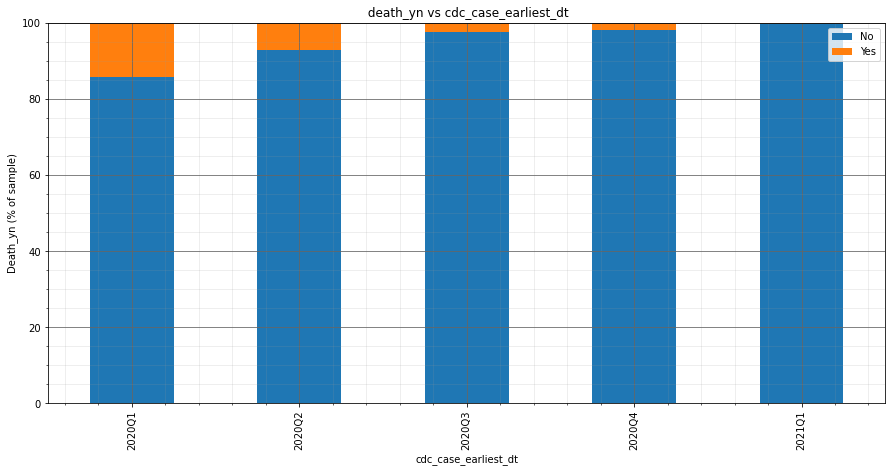

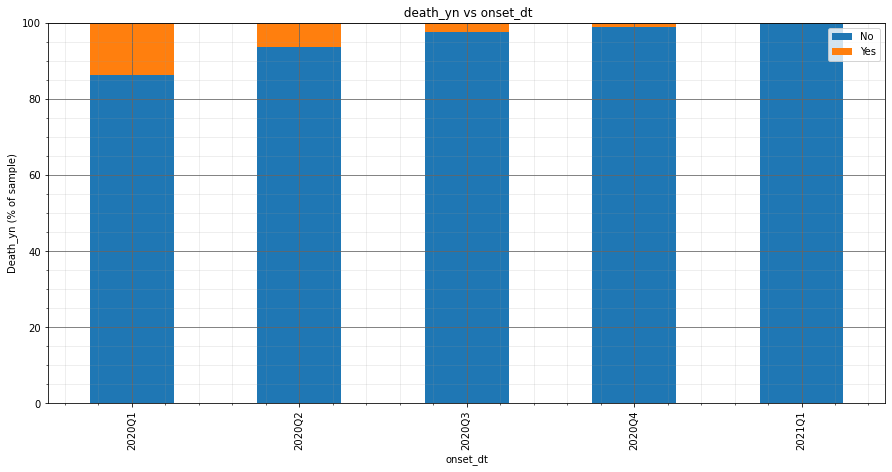

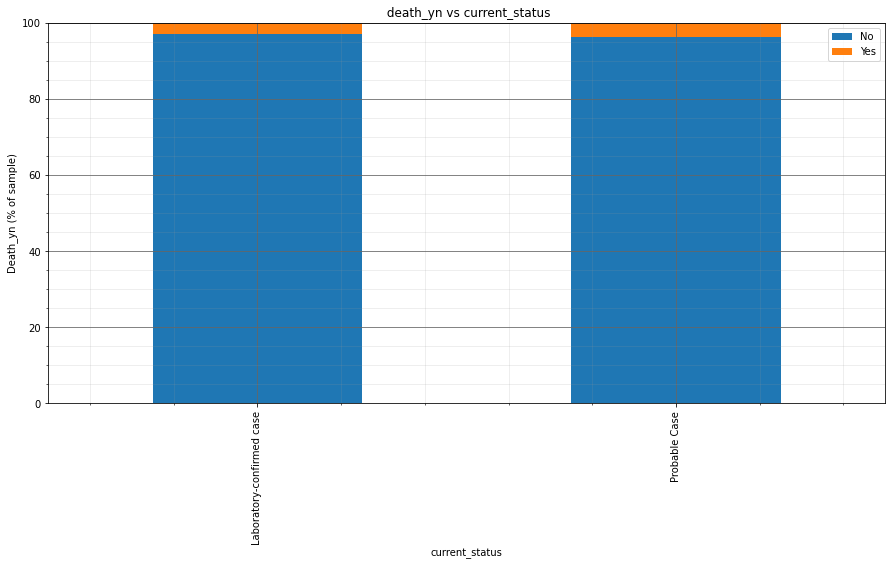

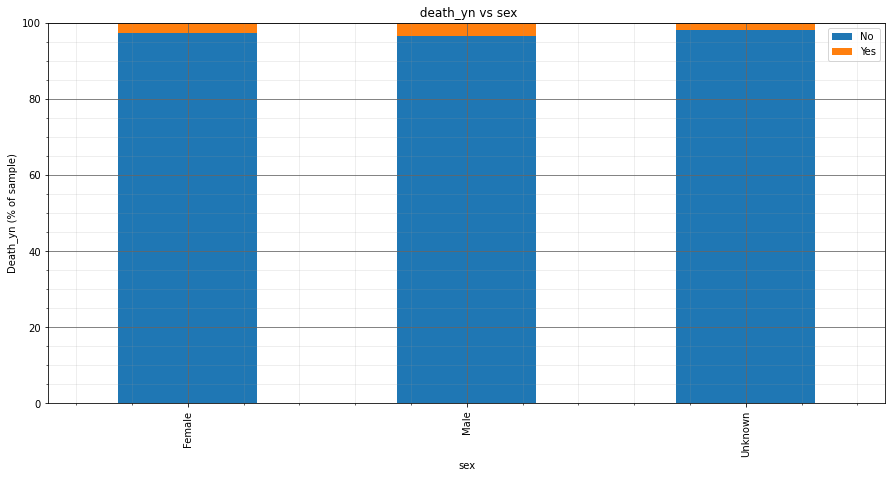

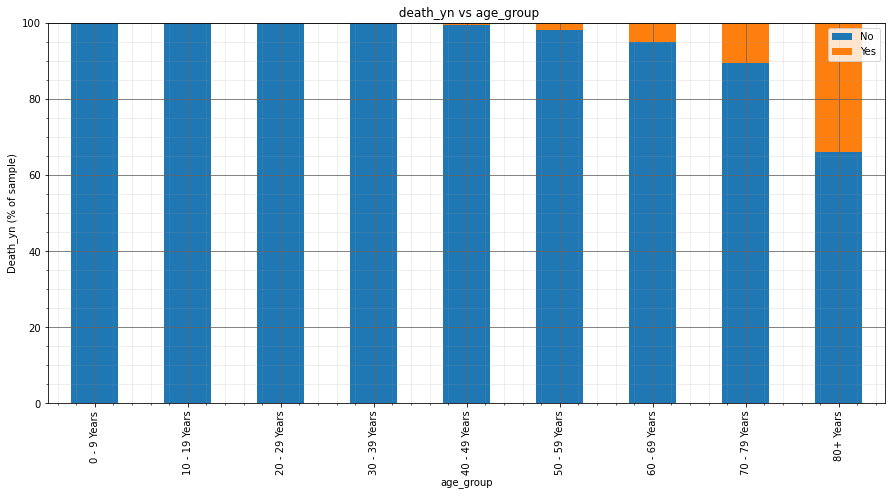

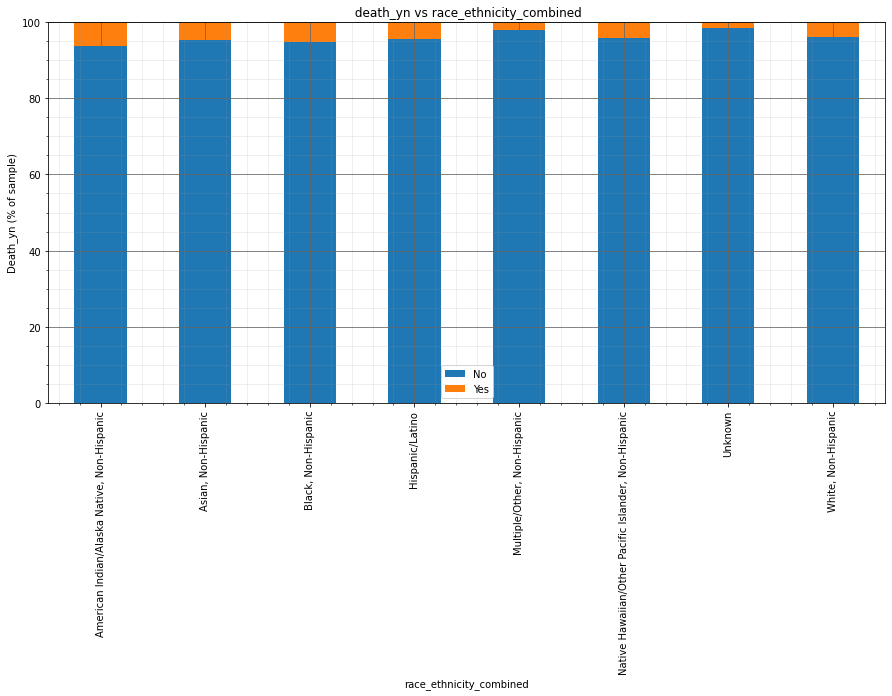

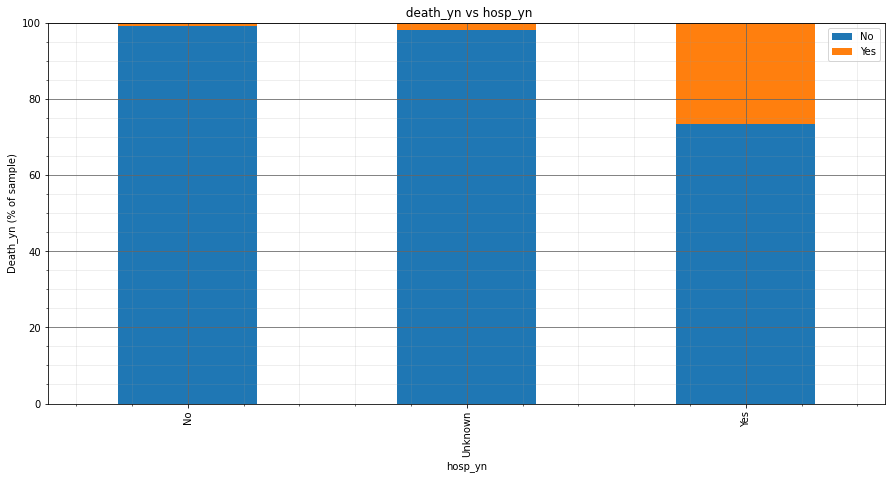

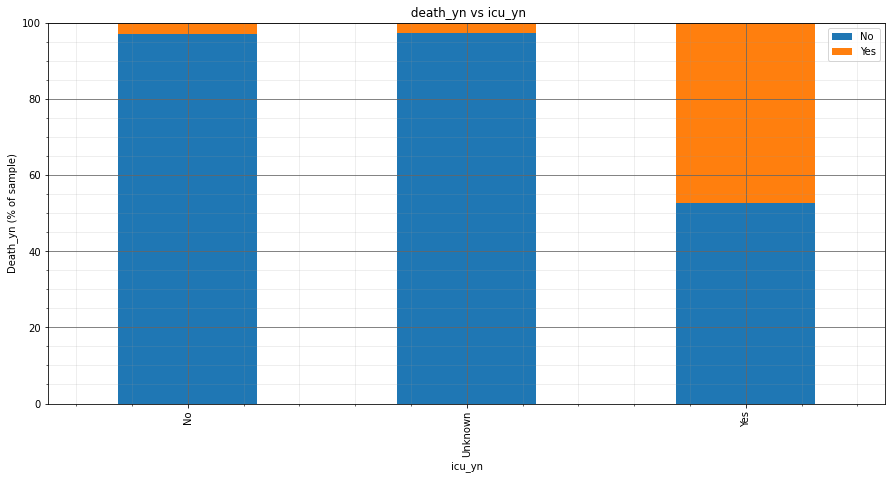

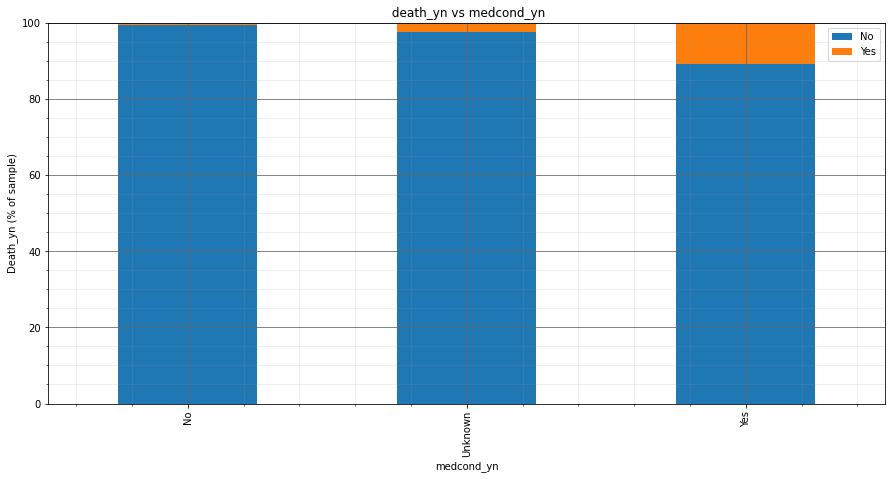

In [35]:

categorical_columns = x.columns.values.tolist()
# for the comparison we will convert the target back to categorical
y_train = y_train.astype("category")
#X_train[categorical_columns].columns
# we will create temp dataframe for these plots, mergeing X_train and y_train
df_temp= pd.concat([x_train, y_train], axis=1)
# for each categorical feature create a stacked bar plot

pp = PdfPages('Stacked_Bar_plots_categorical_vs_catgeorical.pdf')
for categorical_feature in categorical_columns:
    # Using code from the module lab 
    features = pd.unique(df_temp[categorical_feature].ravel())
    # add new column and set values to zero
    df_temp['percent'] = 0
    #print header
    print("\n", categorical_feature)
    print("Index \t Count")
    # for each delinquency category
    for i in features:
        count = df_temp[df_temp[categorical_feature] == i].count()['death_yn']
        count_percentage = (1 / count) * 100
        # print out index vs count
        print(i, "\t", count)
        index_list = df_temp[df_temp[categorical_feature] == i].index.tolist()
        for ind in index_list:
            df_temp.loc[ind, 'percent'] = count_percentage
            
    group = df_temp[['percent',categorical_feature,'death_yn']].groupby([categorical_feature,'death_yn']).sum()
    
    
    my_plot = group.unstack().plot(kind='bar', stacked=True, title=f" death_yn vs {categorical_feature}", figsize=(15,7), grid=True)
    my_plot.legend(["No", "Yes"])
    # add gridlines
    plt.grid(b=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    # add labels
    my_plot.set_xlabel(categorical_feature)
    my_plot.set_ylabel("Death_yn (% of sample)")
    my_plot.set_ylim([0,100])  
# drop 'percent' that was used only for stacked bar plot
df_temp = df_temp.drop("percent", 1)
pp.close()

These stacked bar plots give us a good indication of the ratio of the target feature values for each category, below are small multiple bar plots for each feature to help us get an even better understanding of these features and how they relate to the target features. Below each plot is a quick summary detailing the results and what they mean for our model.

### Sex vs. Death

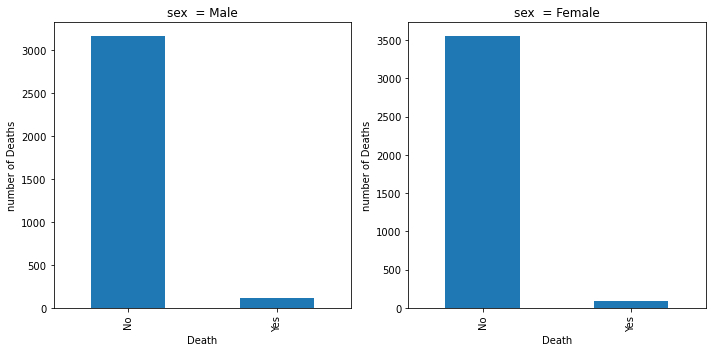

In [36]:
sex = pd.unique(df["sex"].ravel())
for i in range(0,2):

    plt.subplot(1, 2, i+1) # row 1, col 2 index 1
    group1 = df_train[df_train["sex"]==sex[i]]
    f = group1["death_yn"].value_counts().plot(kind='bar', figsize=(10,5))
    plt.title("sex  = {}".format(sex[i]))
    plt.ylabel('number of Deaths')
    plt.xlabel('Death')
plt.tight_layout()
plt.savefig('1.png')
plt.show()

Above we can see the bar plots for number of deaths of those who are Male and those who are female. The two plots are very similar with almost equal levels of deaths, however males mortality rates are marginally higher than females. Global data indicate higher COVID-19 case fatality rates among men than women. Most countries with available data indicate a male to female case fatality ratio higher than 1:0, ranging up to 3:5 in some cases. Therefore this feature will be kept in the model.


### Age group vs. Death

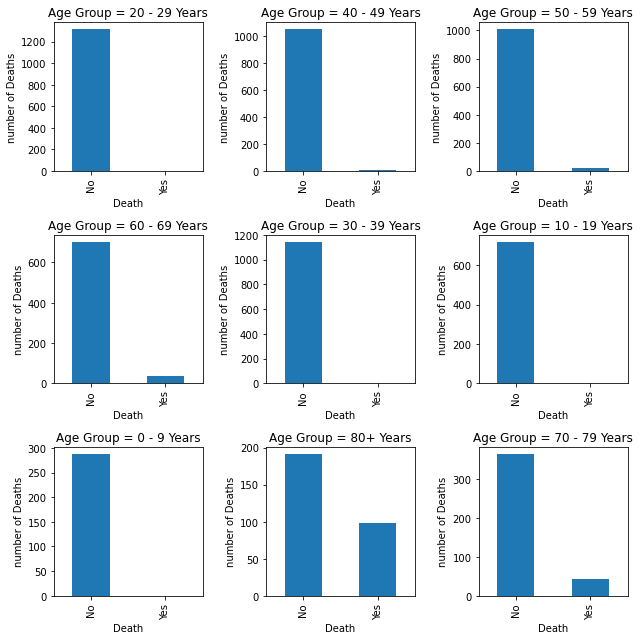

In [37]:
age_group = pd.unique(df["age_group"].ravel())
for i in range(0,9):

    plt.subplot(3, 3, i+1) # row 1, col 2 index 1
    group1 = df_train[df_train["age_group"]==age_group[i]]
    f = group1["death_yn"].value_counts().plot(kind='bar', figsize=(9,9))
    plt.title("Age Group = {}".format(age_group[i]))
    plt.ylabel('number of Deaths')
    plt.xlabel('Death')
plt.tight_layout()
plt.savefig('2.png')
plt.show()

Plot summary:

- The data is as expected, with death rates increasing as age increases from 0-9 years up to 80+ years.
- This trend begins at 40-49  years and then almost doubles for each subsequent age grouping.
- from this plot we can be assured that the age and death data is correct as this increasing trend in death rates is as expected 
- This feature will be kept in our model.

## hospital vs. death 

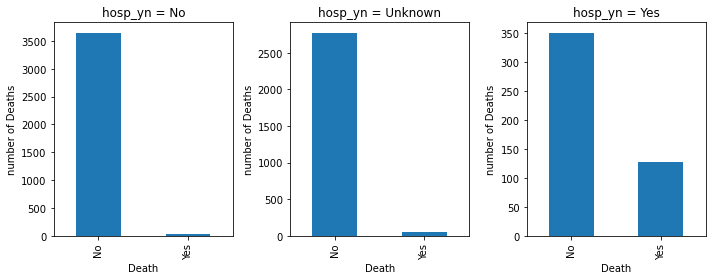

In [38]:
hosp_yn = pd.unique(df["hosp_yn"].ravel())
for i in range(0,3):

    plt.subplot(1, 3, i+1) # row 1, col 2 index 1
    group1 = df_train[df_train["hosp_yn"]==hosp_yn[i]]
    f = group1["death_yn"].value_counts().plot(kind='bar', figsize=(10,4))
    plt.title("hosp_yn = {}".format(hosp_yn[i]))
    plt.ylabel('number of Deaths')
    plt.xlabel('Death')
    plt.tight_layout()
plt.tight_layout()    
plt.savefig('3.png')
plt.show()

Plot summary:

- The figures are as expected. relative to the number of people who did not die in that category the number of deaths of those who have been hospitalized is much greater than those who have not.

- We must also take account for the fact that in total the number of people not hospitalized is far greater than the number of those who were and this therefore leads to different scales used on the axis of these plot. While the plots would lead you to believe that the total number of people who died who were hospitalized is far greater, they are actually roughly the same in both plots (~200).
- This is evidently a very strong risk factor and as such will be kept in our model.

## ICU vs. death 

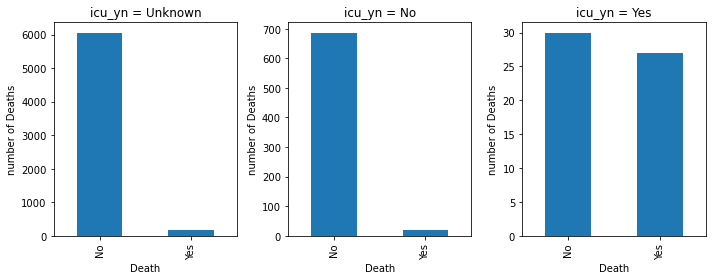

In [39]:
icu_yn = pd.unique(df["icu_yn"].ravel())
for i in range(0,3):

    plt.subplot(1, 3, i+1) # row 1, col 2 index 1
    group1 = df_train[df_train["icu_yn"]==icu_yn[i]]
    f = group1["death_yn"].value_counts().plot(kind='bar', figsize=(10,4))
    plt.title("icu_yn = {}".format(icu_yn[i]))
    plt.ylabel('number of Deaths')
    plt.xlabel('Death')
    plt.tight_layout()
plt.tight_layout() 
plt.savefig('4.png')
plt.show()

Plot summary:

- The figures are as expected. relative to the number of people who did not die in that category the number of deaths of those who have been to admitted to ICU is much greater than those who have not. There is roughly a 50:50 split in mortality for those who are admitted to ICU. 

- While a very large proprtion of rows of this feature were missing and imputed with an unknown value, we can still see the risk factor associated with ICU admission. This feature will therefore be kept in our model.

## Medical Condition vs. death 

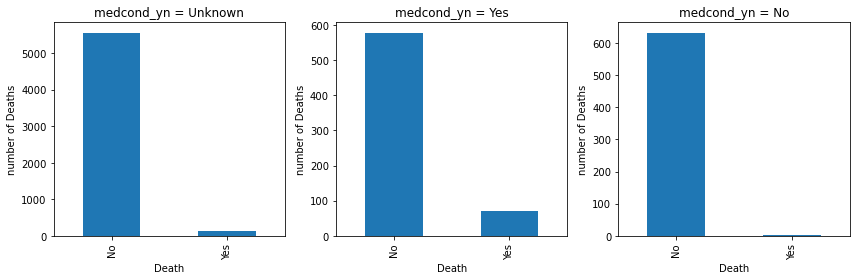

In [40]:
medcond_yn = pd.unique(df["medcond_yn"].ravel())
for i in range(0,3):

    plt.subplot(1, 3, i+1) # row 1, col 2 index 1
    group1 = df_train[df_train["medcond_yn"]==medcond_yn[i]]
    f = group1["death_yn"].value_counts().plot(kind='bar', figsize=(12,4))
    plt.title("medcond_yn = {}".format(medcond_yn[i]))
    plt.ylabel('number of Deaths')
    plt.xlabel('Death')
    plt.tight_layout()
    
plt.tight_layout()  
plt.savefig('5.png')
plt.show()

Plot summary:

- Similarly to icu_yn, a large number of the missing values were imputed with an unknown value and therefore this category takes up the large majority of this features values. 
- Roughly the same amount of people (~600) both with and without underlying medical conditions did not die. However the mortality rate among those with underlying medical conditions is far greater than those without.
- It is well documented that underlying medical conditions are a determining factor when it comes to covid related mortality, and therefore we will be keeping this feature in our model.

## race/ethnicity vs. death 

In [41]:
#percentage of labels in original dataframe 
print(df_train["race_ethnicity_combined"].value_counts()/df_train["race_ethnicity_combined"].value_counts().sum())

Unknown                                                 0.412169
White, Non-Hispanic                                     0.334431
Hispanic/Latino                                         0.095490
Black, Non-Hispanic                                     0.071725
Multiple/Other, Non-Hispanic                            0.051396
Asian, Non-Hispanic                                     0.024481
American Indian/Alaska Native, Non-Hispanic             0.006872
Native Hawaiian/Other Pacific Islander, Non-Hispanic    0.003436
Name: race_ethnicity_combined, dtype: float64


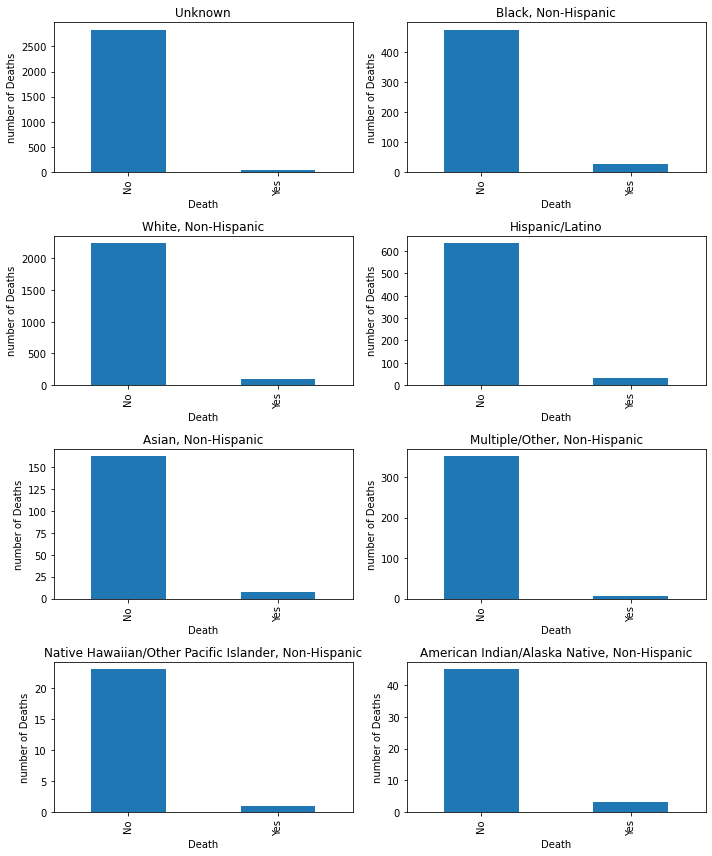

In [42]:
race_ethnicity_combined = pd.unique(df["race_ethnicity_combined"].ravel())
for i in range(0,8):
    plt.subplot(4,2, i+1) # row 1, col 2 index 1
    group1 = df_train[df_train["race_ethnicity_combined"]==race_ethnicity_combined[i]]
    f = group1["death_yn"].value_counts().plot(kind='bar', figsize=(10,12))
    plt.title("{}".format(race_ethnicity_combined[i]))
    plt.ylabel('number of Deaths')
    plt.xlabel('Death')
    plt.tight_layout()
plt.tight_layout()  
plt.savefig('6.png')
plt.show()

Plot summary:

- If we look back at the stacked bar plot we can see that the death rate does not vary significantly from one race to another.
- The death rate variation among different race/ ethnicities seems quite low.
- while they are all relatively low it would seem that 'black, Non-Hispanic' and 'White, non-Hispanic' have the highest amount of deaths.
- while 'Multiple/Other, Non Hispanic' has the lowest percentage of deaths. 

## current_status vs. death 

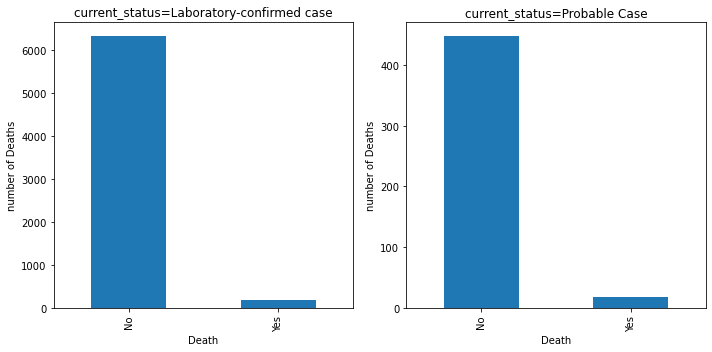

In [43]:
current_status = pd.unique(df["current_status"].ravel())
for i in range(0,2):
    plt.subplot(1,2, i+1) # row 1, col 2 index 1
    group1 = df_train[df_train["current_status"]==current_status[i]]
    f = group1["death_yn"].value_counts().plot(kind='bar', figsize=(10,5))
    plt.title("current_status={}".format(current_status[i]))
    plt.ylabel('number of Deaths')
    plt.xlabel('Death')

plt.tight_layout() 
plt.savefig('7.png')
plt.show()

Plot summary:

- We can see the the majority of laboratory confirmed cases do not result in death, this is as expected as the the mortality rate in most countries remains below 5%. In Ireland for example the mortality rate sits at around 2% of confirmed cases. 
- Therefore this feature does provide some useful information, but it would not add much to a predictive model. For the most part the predicitve model will be used to predict the risk factor for confirmed cases and therefore current_status would not be variable. 


## cdc_case_earliest_dt vs death  

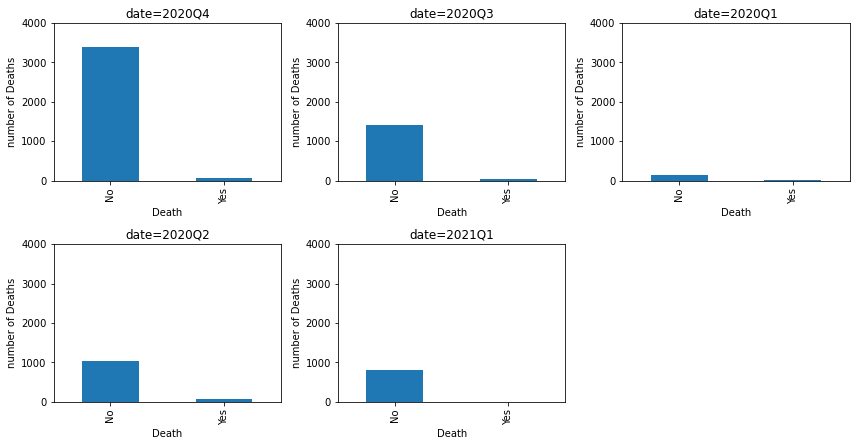

In [44]:
cdc_case_earliest_dt = pd.unique(df["cdc_case_earliest_dt"].ravel())

for i in range(0,5):
    plt.subplot(5,3, i+1) # row 1, col 2 index 1
    group1 = df_train[df_train["cdc_case_earliest_dt"]==cdc_case_earliest_dt[i]]
    f = group1["death_yn"].value_counts().plot(kind='bar', figsize=(12,15), ylim=(0,4000))
    plt.title("date={}".format(cdc_case_earliest_dt[i]))

    plt.ylabel('number of Deaths')
    plt.xlabel('Death')

plt.tight_layout()  
plt.savefig('8.png')
plt.show()

Plot summary: 

- These plots serve as an indication of how many cases occured over the year period that this data was collected. As we can see the mortality rate for each quarter is very low and it would seem that the quarter in which the cases were infected with the virus has very little affect on the target feature. Even in quarters where case level was at its highest (2020Q4), the mortality rate remains relatively the same as other months where case level wasn't near as high. 
- This feature will not be used in the initial statistical model as it is not a high risk factor. Based on these plots it would seem that it has very little afect on the target feature. In countries with very little medical resources this may be a risk factor as hospitals would be overworked in the winter which could result in more deaths. In america they have a sophisticated (but expensive!) medical system that can withstand high levels of patient admittance. 
- if we look at the stacked bar plots for this feature we can see that there was a surge in cases and deaths in the first quarter of 2020 due to the fact that the pandemic had just begun, as the year moves on the death rate lowers and levels out significanlty. Even through the winter quarter of the year the death rates remain quite low.

## Onset_dt vs Death

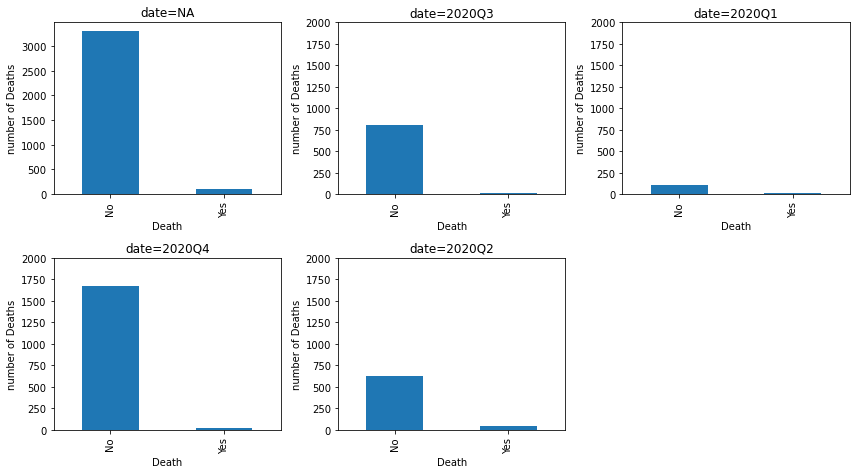

In [45]:
onset_dt = pd.unique(df["onset_dt"].ravel())
plt.subplot(5,3,1)
NAT_group = df_train[df_train["onset_dt"].isna()]
f = NAT_group["death_yn"].value_counts().plot(kind='bar', figsize=(12,12))
plt.title("date=NA")
plt.ylabel('number of Deaths')
plt.xlabel('Death')


for i in range(1,5):
    plt.subplot(5,3, i+1) # row 1, col 2 index 1
    group1 = df_train[df_train["onset_dt"]==onset_dt[i]]
    f = group1["death_yn"].value_counts().plot(kind='bar', figsize=(12,16), ylim=(0,2000))
    plt.title("date={}".format(onset_dt[i]))
    plt.ylabel('number of Deaths')
    plt.xlabel('Death')

plt.tight_layout() 
plt.savefig('9.png')
plt.show()

Plot summary: 

- These plots provide similar results to cdc_case_earliest_dt. For the same reasons as cdc_case_earliest_dt they will not be included in the statistical model. Not only are over half of the dates missing, but the quarter in which symptoms begin to show is simply not a risk factor that would need to be accounted for in our predictive model. cdc_case_earliest could be use as the sole indicator of datetime of the deaths, this will be looked at in more detail in section 5. But for now, these two datetime features will not be included in our initial predictive model.

### Summary of findings

- **Categorical vs Categorical features:**
   - From the bar plot it is clear that roughly the same amount of males and females died as a result of covid-19, with males having a marginally higher death rate. Global data indicate higher COVID-19 case fatality rates among men than women. Therefore this feature will be kept in the model.
   
   - We see a strong link between increasing age and death rate as is expected. This feature will be kept in the model.
   
   - The pairwise analysis of hospilization vs. death rate is as expected, in general those who were hospitalized have a higher chance of dying from covid-19. The large majority of this sample were not hospitalized. roughly 700 people were, and of those 700 approximately 200 died, as is evident from the bar plot above. This feature will be kept in the model.
   
  - There is roughly a 50:50 split in mortality for those who are admitted to ICU. This feature is a high risk factor and will therefore be kept in the model.
   
  - The number of deaths of those with an underlying medical condition is far higher than those without, it is well documented that this is a high risk factor and therefore it will be included in our model. 
   
  - There are no evident links between race/ethnicity and death rate, it would seem that the death rate percentage across the groupings of ethnicities is quite similar. It was pointed out above how two of these groups have a marginally higher percentage of deaths, but this could be due to the fact that 'white, non hispanic' and 'black, non hispanic' make up a large proportion of the data set, in particular 'white, non hispanic' which is the modal value of *race_ethnicity_combined* in our most up to date dataframe. We will look at this feature again in section 5.
  
  - There is no evident link between current_status and death rate. 
  
  - There is no evident link between onset_dt and death rate for the reasons explained above.
  
  - There is no evident link between cdc_case_earliest_dt and death rate for the reasons explained above.  We will look at this feature again in section 5.
  

  
  
- **Subset of Categorical variables for predictive model:**
    - Based on this analysis, the variables that seem better at predicting the target feature and that will will be used in our predictive model are:
        - sex 
        - age_group
        - hosp_yn
        - icu_yn
        - medcond_yn

## 1.3 Prepare dataset for modeling
Now we have picked our descriptive features for the whole dataset, a number of additional steps will need to be taken to prepare the dataset for modeling 
- We will drop those features that we did not deem suitable for predicting the target feature.
- We will convert the categorical variables into indicator variables such that modelling can be done
- We will then remove the redundant dummies which contain no additional information
- We will then set up the train test split again based on the dataset with the dummies included
- model training can then begin 


In [46]:
#making a copy of original dataframe
df_reduced = df.copy()

In [47]:
#drom features that were deemed unsuitable for predictions 
df_reduced = df.drop(['cdc_case_earliest_dt','onset_dt','current_status','race_ethnicity_combined'],axis=1)

Our data is made up of only categorical features and therefore we must deal with this as linear regression expects numerical features. This is done through dummy encoding which can be seen below, we turn each categorical feature into many binary continuous features that encode the levels of the categorical feature. 

In [48]:
#converting categorical data into dummy or indicator variables 
variables = ['age_group','hosp_yn','icu_yn','medcond_yn','sex']
for col in variables:
    dummies = pd.get_dummies(df_reduced[col],prefix = col, drop_first=True)
    df_reduced = pd.concat([df_reduced,dummies], axis = 1)

In [49]:
#dropping unused columns
df_reduced = df_reduced.drop(variables, axis=1)

In [50]:
#mapping the target feature to binary digits, 1 for yes and 0 for no. 
df_reduced['death_yn'] = df_reduced['death_yn'].map({'Yes': 1, 'No': 0})

### Setting up the train/test split
- This is based on the dataset with dummy values
- The Target is stored in dataframe "y"
- The remaining features are stored in dataframe "X"
- Both are split into training and test subsets

In [51]:
#creating variables and target feature 
x = df_reduced.drop('death_yn',axis=1)
y = df_reduced['death_yn']

In [52]:
#print the categorical feature
categ_features = x.columns.values.tolist()
print("The variables of our model are: ")
categ_features

The variables of our model are: 


['age_group_10 - 19 Years',
 'age_group_20 - 29 Years',
 'age_group_30 - 39 Years',
 'age_group_40 - 49 Years',
 'age_group_50 - 59 Years',
 'age_group_60 - 69 Years',
 'age_group_70 - 79 Years',
 'age_group_80+ Years',
 'hosp_yn_Unknown',
 'hosp_yn_Yes',
 'icu_yn_Unknown',
 'icu_yn_Yes',
 'medcond_yn_Unknown',
 'medcond_yn_Yes',
 'sex_Male',
 'sex_Unknown']

In [53]:
#splitting the dataset
#random state of train test split will remain at 5 for duration of this assignment to create reproducable results
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=5)
print("original range is: ",df_reduced.shape[0])
print("training range (70%):\t rows 0 to", round(x_train.shape[0]))
print("test range (30%): \t rows", round(x_train.shape[0]), "to", round(x_train.shape[0]) + x_test.shape[0])

original range is:  9979
training range (70%):	 rows 0 to 6985
test range (30%): 	 rows 6985 to 9979


#### Reset the indexes of the training and test splits

- When the train_test_split library is used it shuffles the index of the dataframe, therefore we will reset the index to its original order.
- This must be dealt with as it will effect merging of dataframes in the coming sections

In [54]:
# need to reset the index to allow concatenation with predicted values
x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# 2. Predictive modelling: Linear Regression

## 2.1 Training the model 
 
The linear regression model will now be trained using the training data from above.

In [55]:
# Train on the training sample and test on the test sample.
linreg = LinearRegression().fit(x_train, y_train)

## 2.2 Interpreting the model

Below are the intercept and model coefficients of the linear regression model, this model will be discussed in more detail now. 

In [56]:
#print the model intercept
print("Model Intercept:",linreg.intercept_)

Model Intercept: -0.03254920471241114


In [57]:
# Print the weights learned for each feature.
#print(linreg_train.coef_)
print("Features and coeficients:")
list(zip(categ_features, linreg.coef_))

Features and coeficients:


[('age_group_10 - 19 Years', 0.0025093512061439135),
 ('age_group_20 - 29 Years', 0.0018031365877110254),
 ('age_group_30 - 39 Years', 5.151296513474523e-05),
 ('age_group_40 - 49 Years', 0.0004953404065557065),
 ('age_group_50 - 59 Years', 0.00797735229485094),
 ('age_group_60 - 69 Years', 0.02316281527258219),
 ('age_group_70 - 79 Years', 0.06428348119740449),
 ('age_group_80+ Years', 0.27165925542818103),
 ('hosp_yn_Unknown', 0.012290424236981061),
 ('hosp_yn_Yes', 0.16418798057577053),
 ('icu_yn_Unknown', 0.030955100290881568),
 ('icu_yn_Yes', 0.2546350452469216),
 ('medcond_yn_Unknown', -0.013094233192064273),
 ('medcond_yn_Yes', 0.027408773626882398),
 ('sex_Male', 0.01171798956236739),
 ('sex_Unknown', -0.006926352167393863)]

**Interpreting the model:**

Multiple linear regression attempts to model the relationship between two or more explanatory variables and a response variable by fitting a linear equation to the observed data. Every value of the independent variable x is associated with a value of the dependent variable y.

The linear regression formula takes the following form:

- $y = x0 + B1 * x1 + B2*x2 + ...+ Bn*xn $
    - where y represents the target feature of interest .
    - B represents the model coefficents. 
    - x represents the model variables.

As this is a multiple linear regression model consisting of all categorical features, the different levels of the variables of the model can be thought of as switches where they are labelled 1 if they are 'on' and 0 if they are 'off'. The reference level of the each feature is then 'on' when all of the other levels are turned 'off' or 0. Therefore the model coefficients seen above can be thought of as a resulting change of the feature when compared to the reference level. The intercept value -0.0325 indicates the base value of the model. This is the model in which all of the reference levels are turned on i.e all variables are 0.

It is important to note that the output from a linear regression model is not suited to the classification problem that we are trying to solve.
- The output is not a probability and an additional thresholding step is necessary to convert the output into a binary classification
- We will threshold the output so that any values >=0.5 will be cast to 1, any values <0.5 will be cast to 0

The coefficicents above can be interpreted as follows:

- if we look firstly at the various levels of the age group category, there are a total of 9 different levels with 0 - 9 Years being the reference level. The reference level of age_group is 'on' when all of the other levels are 0 or turned off. Therefore we interpret the model as follows, a change from the reference level 0-9 years to level 80+ years results in a 0.27 change in the target feature (risk of death). 

- If we move down the list to hosp_yn we can see that the reference level of hosp_yn is set to no, therefore a change from the reference level no to yes results in a 0.164 change in the risk of death. these coeffiecents are as expected, as we would expect an increase in risk of death for a patient who must be hospitalized after contracting covid-19.

- Form this analysis we can see that those with medical conditions will have a resulting change of 0.027 in risk level  than those without and that men will have an increase of 0.012 in risk level when compared to women.

## 2.3 Model predictions and metrics 

We will print the predicted target feature value and the predicted class for the first 10 training examples based on training data.

In [58]:
#predicted target feature for first 10 training examples 
train_predictions = linreg.predict(x_train)
for i in range(0,10):
    print("prediction {}: ".format(i+1), train_predictions[i])

prediction 1:  0.009815416592310312
prediction 2:  0.009815416592310312
prediction 3:  0.009815416592310312
prediction 4:  0.011123212773465625
prediction 5:  0.00937158915088935
prediction 6:  -0.012885201025882823
prediction 7:  0.0618855678207917
prediction 8:  -0.014192997207038135
prediction 9:  0.005007004243624477
prediction 10:  0.06131313314617802


As we can see above, the predicitons produced are continuous due to the fact that we have fitted a linear model, this is why we must use a threshold value to classify these results. For this assignment this threshold value will be taken as 0.5 i.e if the predicted value is greater than 0.5 then the target feature will be classified as 1 (death_yn = yes), otherwise if it is below it will be classified as 0.

In [59]:
# Threshod the predicted probs for all trainig examples and store them.
linreg_predicted_class = (linreg.predict(x_train) >= 0.5) * 1.0
print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelinreg = pd.DataFrame({'Actual Class': y_train, 'Predicted Class': linreg_predicted_class})

#print the actual class and the predicted class
print(actual_vs_predicted_multiplelinreg.head(10))


Predictions with multiple linear regression: 

  Actual Class  Predicted Class
0            0              0.0
1            0              0.0
2            0              0.0
3            0              0.0
4            0              0.0
5            0              0.0
6            1              0.0
7            0              0.0
8            0              0.0
9            0              0.0


### Evaluation metrics on training set.

We will print the classification evaluation measures computed on the training set (e.g. Accuracy, Confusion matrix, Precision, Recall, F1)

In [60]:
#printing the evaluation metrics for training set
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, linreg_predicted_class), "\n")
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, linreg_predicted_class), "\n")
print("Classification report:\n ", metrics.classification_report(y_train, linreg_predicted_class))
print("======================================================")

==================== Train Data =======================
Accuracy:  0.9715103793843951 

Confusion matrix: 
 [[6775    1]
 [ 198   11]] 

Classification report:
                precision    recall  f1-score   support

           0       0.97      1.00      0.99      6776
           1       0.92      0.05      0.10       209

    accuracy                           0.97      6985
   macro avg       0.94      0.53      0.54      6985
weighted avg       0.97      0.97      0.96      6985



Discussion of evaluation metrics on training set:

- Accuracy
    - this is an indication of how often the model is correct, we have an accuracy of 97%. 
- Confusion Matrix 
    - 6775 represents the true negative - The number that is predicted 0 that was actually 0, 
    - 1 represents the false positive - The number that is predicted 1 that is actually 0
    - 198 represents the false negative - The number that is predicted 0 that is actually 1
    - 11 represents the true positive - The number that is predicted 1 that is actually 1
- Precision 
    - this is an indication of how good the model is at predicting the positive class 
    - precision for predicting postive class is 0.92
    - precision for predicitng negative class is 0.97
- Recall
    - this indicates the percentage of the positive class values that we predicted
    - recall for positive class is 0.05 - this is quite low.
    - recall for negative class is 1
- F1 
    - this is a weighted average of precision and recall
    - positive class f1 score is 0.1
    - negative class f1 score is 0.99

Summary 

It is evident that the model predicts the negative class better than the positive class, we must however take into consideration that this is a heavily imbalanced classification problem and therefore this result reflects the fact that the model has far more negative class data to learn from as it is the majority class. We can see from the confusion matrix that 198 cases were predicted as 0 when they were actually 1. This is a significant error considering the fact that this model is trying to determine the death risk factor. The high precision and low recall for the positive class indicates that the class is well detected but the model also include points of other classes in it.

## 2.4 Model evaluation

### Evaluation of model on hold out test set

We will now do the same evaluation using the test set, these results are printed below along with the training set results for comparison.

In [61]:
# Threshod the predicted probs for all the 10 examples and store them.
linreg_predicted_class_testset = (linreg.predict(x_test) >= 0.5) * 1.0
print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelinreg = pd.DataFrame({'Actual Class': y_test, 'Predicted Class': linreg_predicted_class_testset})
print(actual_vs_predicted_multiplelinreg.head(10))


Predictions with multiple linear regression: 

  Actual Class  Predicted Class
0            0              0.0
1            0              0.0
2            1              0.0
3            0              0.0
4            0              0.0
5            0              0.0
6            0              0.0
7            0              0.0
8            0              0.0
9            0              0.0


In [62]:
#printing evaluation metrics for train and test data 
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, linreg_predicted_class), "\n")
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, linreg_predicted_class), "\n")
print("Classification report:\n ", metrics.classification_report(y_train, linreg_predicted_class))
print("==================== Test Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_test, linreg_predicted_class_testset))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, linreg_predicted_class_testset))
print("Classification report:\n ", metrics.classification_report(y_test, linreg_predicted_class_testset))
print("======================================================")

==================== Train Data =======================
Accuracy:  0.9715103793843951 

Confusion matrix: 
 [[6775    1]
 [ 198   11]] 

Classification report:
                precision    recall  f1-score   support

           0       0.97      1.00      0.99      6776
           1       0.92      0.05      0.10       209

    accuracy                           0.97      6985
   macro avg       0.94      0.53      0.54      6985
weighted avg       0.97      0.97      0.96      6985

==================== Test Data =======================
Accuracy:  0.9645958583834335
Confusion matrix: 
 [[2887    2]
 [ 104    1]]
Classification report:
                precision    recall  f1-score   support

           0       0.97      1.00      0.98      2889
           1       0.33      0.01      0.02       105

    accuracy                           0.96      2994
   macro avg       0.65      0.50      0.50      2994
weighted avg       0.94      0.96      0.95      2994



Discussion of evaluation metrics on training set:

- Accuracy
    - Accuracy of the test data is marginally lower at 0.96

- Precision 
    - precision for predicting postive class reduced significantly from 0.92 to 0.33
    - precision for predicitng negative class stayed the same 
    - we can see from the confusion matrix that the number of true positives is very low
    - this indicates that the model may not be predicting the positive class as well as we would like
    
- Recall
    - recall for prediciting negative case remained at 1
    - recall for predicting positive case dropped from 0.05 to 0.01
     
- F1 
    - The f1 score for predicting the positive case has marginally decreased from 0.99 to 0.98
    - The f1 score for predicting the negative case has decreased from 0.1 to 0.2

Summary 

While the accuracy of the model stays quite high, the drop in precision is cause for concern as it shows that the model is not predicting the positive class very well. this could be due to the fact that the model is overfitted or that linear regression is not a suitable method for this classification problem. We will now make some more comparisons using cross validation. 

### Cross Validation 

In order to put the model to the test a number of times we use cross validation. It is the same evaluation as above, except it is performed a number of times on different shuffled data sets which are then split into train and test sets. Due to the fact that Sklearn does not provide a function to perform cross validation for linear regression, we have to produce this function ourselves. This is achieved by creating a wrapper function for the linear regression package that turns the results into classification results, and then these can be passed to another function that performs the cross validation as normal.


In [63]:
#function to perform cross validation on the linear regression model 
def cross_val_LinReg(X, y, cv=3, scoring='accuracy'): 
    results = []
    
    # iterating over i such that random state can be changed for each iteration
    for i in range(cv):
        #train test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i , test_size=0.3)
        #training model 
        multiple_linreg = LinearRegression().fit(X_train, y_train)
        multiple_linreg_predictions = (multiple_linreg.predict(X_test) >= 0.5) * 1.0
        #calculating the score for varying metrics 
        if scoring=='accuracy':
            score = metrics.accuracy_score(y_test, multiple_linreg_predictions)
        elif scoring=='precision':
            score = metrics.precision_score(y_test, multiple_linreg_predictions)
        elif scoring=='f1':
            score = metrics.f1_score(y_test, multiple_linreg_predictions)
        elif scoring=='recall':
            score = metrics.recall_score(y_test, multiple_linreg_predictions)
        #append results
        results.append(score)
    return results

In [64]:
#function to perform 10 fold cross validation and store results in a dataframe 
def cross_val_LinReg_DF(X,y):
    #results stored in a dict 
    linRegResults = {}
    #metrics to be calculated
    test_metrics = ['accuracy','precision','recall', 'f1']  
    #perorm cross validation for each metric 
    for metric in test_metrics:
        result = cross_val_LinReg(X, y, cv=10, scoring=metric)
        length = len(result)
        #get the average result 
        linRegResults[metric] = sum(result)/length
    #vretae dataframe to be returned
    LinRegDF = pd.DataFrame.from_dict(linRegResults, orient='index', columns=['Linear_Regression'])
    return LinRegDF

In [65]:
#performing cross validation on the linear model 
linreg_crossval_df = cross_val_LinReg_DF(x,y)
print(f"Mean results from 10 fold cross validation are:")
linreg_crossval_df

Mean results from 10 fold cross validation are:


,Linear_Regression
accuracy,0.968470
precision,0.773333
recall,0.031295
f1,0.060018


Summary of findings:

- accuracy remains very high, this is representative of the fact that the dataset is highly imbalanced and therefore there is only a small number of positive cases in the dataset.
- while the precision is relatively high at 77%, recall remains very low, and thus drags down the f1 value of the model.
- It would seem that the linear regression model is not performing very well with this classification problem, in section 5 we will attempt to improve this model with a number of modelling techniques.


# 3. Predictive Modelling: Logistic regression 

## 3.1 Training the model 

The logistic regression model will now be trained using the same training data.

In [66]:
# Train on the training sample and test on the test sample.
LogReg = LogisticRegression().fit(x_train, y_train)

## 3.2 Interpreting the model

Below are the intercept and model coefficients of the logistic regression model, this model will be discussed in more detail now. 

In [67]:
#printing the model intercept 
print("Model Intercept:",LogReg.intercept_)

Model Intercept: [-6.68477283]


In [68]:
#printing the model coefficients
print("Features and coeficients:")
list(zip(categ_features, LogReg.coef_[0]))

Features and coeficients:


[('age_group_10 - 19 Years', -1.3451698092791429),
 ('age_group_20 - 29 Years', -0.9901127349096263),
 ('age_group_30 - 39 Years', -1.706301115167833),
 ('age_group_40 - 49 Years', -0.3901882231007805),
 ('age_group_50 - 59 Years', 0.4923190341673999),
 ('age_group_60 - 69 Years', 1.1585652326612952),
 ('age_group_70 - 79 Years', 1.8075600757064978),
 ('age_group_80+ Years', 3.3196408287695607),
 ('hosp_yn_Unknown', 0.9755475255646212),
 ('hosp_yn_Yes', 2.5390528379981894),
 ('icu_yn_Unknown', 0.9189440708946183),
 ('icu_yn_Yes', 1.7614524411178987),
 ('medcond_yn_Unknown', -0.01588289745703596),
 ('medcond_yn_Yes', 0.9814305763418204),
 ('sex_Male', 0.5459159735859938),
 ('sex_Unknown', -0.2596739145002049)]

Logistic regression is quite simialr to linear regression, however with logistic regression the relationship between the categorical dependent variable and one or more independent variables is measured by estimating probabilities using a logistic function, which is the cumulative distribution function of logistic distribution. Unlike linear regression, logistic regression is to be used when the dependant variable is binary in nature and outputs a probability between 0 and 1. The logistic regression model automatically applies a threshold to the outputted probability such that values which are greater than or equal to 0.5 are cast to 1 and those less than 0.5 are cast to 0. 

The model estimated in logistic regression is given by the logistic function: <br>

$p(target=1|descriptive\_features)=log(x0 + B1 * x1 + B2*x2 + ...+ Bn*xn) $ <br>


where $log(x)$ is defined as: $log(x) = \frac{e ^ x}{1 + e ^ x} = \frac{1}{1+e^{-x}}$

- From the values above can see the calculated intercept is -6.68
    - This is the reference level i.e. if all other coefficients were zero then the value for 'x' would be -6.68
    - This value represents a person in the 0-9 year age group, who has not been hospitalized or admitted to ICU, who has no underlying medical conditions and is female. Thus why the value is so low, this person has a very low risk of death if they contract covid. 

    
The coefficients above can be interpreted in the same way that the linear regression coefficients were:

- The effect of these on the value 'x' is the same as for linear regression
- if we look firstly at the various levels of the age group category, there are a total of 9 different levels with 0 - 9 Years being the reference level. The reference level of age_group is 'on' when all of the other levels are 0 or turned off. Therefore we interpret the model as follows, a change from the reference level 0-9 years to level 80+ years reults in a 3.32 change in the target feature (risk of death). 

- If we move down the list to hosp_yn we can see that the reference level of hosp_yn is set to no, therefore a change from the reference level no to yes results in a 2.54 change in the risk of death. these coeffiecents are as expected.

- Form this analysis we can see that those with medical conditions have a 0.98 increase in risk level when compared to  those without, and that men have a 0.54 increase in risk level compared to females. 

## 3.3 Model predictions and metrics 

We will print the predicted target feature value and the predicted class for the first 10 training examples based on training data.

In [69]:
# Threshod the predicted probs for all the 10 examples and store them.
logreg_train_predictions = LogReg.predict(x_train)
print("\nPredictions with multiple logistic regression: \n")
actual_vs_predicted_logreg = pd.DataFrame({'Actual Class': y_train, 'Predicted Class': logreg_train_predictions})
print(actual_vs_predicted_logreg.head(10))


Predictions with multiple logistic regression: 

  Actual Class  Predicted Class
0            0                0
1            0                0
2            0                0
3            0                0
4            0                0
5            0                0
6            1                0
7            0                0
8            0                0
9            0                0


### Evaluation metrics on training set. 

We will print the classification evaluation measures computed on the training set (e.g. Accuracy, Confusion matrix, Precision, Recall, F1)

In [70]:
#printing evaluation metrics for train data 
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, logreg_train_predictions),"\n")
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, logreg_train_predictions),"\n")
print("Classification report:\n ", metrics.classification_report(y_train, logreg_train_predictions))
print("=======================================================")

==================== Train Data =======================
Accuracy:  0.972655690765927 

Confusion matrix: 
 [[6731   45]
 [ 146   63]] 

Classification report:
                precision    recall  f1-score   support

           0       0.98      0.99      0.99      6776
           1       0.58      0.30      0.40       209

    accuracy                           0.97      6985
   macro avg       0.78      0.65      0.69      6985
weighted avg       0.97      0.97      0.97      6985



Interpretation of results
- Accuracy
    - We have an accuracy of 0.97 - similar to the linear regression model
- Precision - How good model is at prediction of the positive class
    - Precision for the Positive class is 0.58
    - Precision for the Negative class is 0.98
- Recall - What percentage of the positive values did we predict
    - Recall for the Positive classis 0.3 - higher than the linear model 
    - Recall for the Negative class 0.99
- F1 Score - Is an a weighted average of Precision and recall
    - F1 Score for the Positive class is 0.4
    - F1 Score for the Negative class is 0.99

Summary
- Accuracy is in line with the linear regression model
- It would seem that the logistic model is also a bit better at predicting the positive class.
- recall does remain quite low which is cause for concern as we predict a large number of false negatives.

## 3.3 Logistic Regression Model Evaluation

These results from the test data will be compared the results from the training data. In addition they will be compared to the results from a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset).

### Evaluation of metrics on hold out set

We will now do the same evaluation using the test set, these results are printed below along with the training set results for comparison.

In [72]:
logreg_test_predictions = LogReg.predict(x_test)

#printing evaluation metrics for train and test data 
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, logreg_train_predictions),"\n")
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, logreg_train_predictions),"\n")
print("Classification report:\n ", metrics.classification_report(y_train, logreg_train_predictions))
print("==================== Test Data =======================")

print("Accuracy: ", metrics.accuracy_score(y_test, logreg_test_predictions))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, logreg_test_predictions))
print("Classification report:\n ", metrics.classification_report(y_test, logreg_test_predictions))
print("=======================================================")

==================== Train Data =======================
Accuracy:  0.972655690765927 

Confusion matrix: 
 [[6731   45]
 [ 146   63]] 

Classification report:
                precision    recall  f1-score   support

           0       0.98      0.99      0.99      6776
           1       0.58      0.30      0.40       209

    accuracy                           0.97      6985
   macro avg       0.78      0.65      0.69      6985
weighted avg       0.97      0.97      0.97      6985

==================== Test Data =======================
Accuracy:  0.9655978623914495
Confusion matrix: 
 [[2869   20]
 [  83   22]]
Classification report:
                precision    recall  f1-score   support

           0       0.97      0.99      0.98      2889
           1       0.52      0.21      0.30       105

    accuracy                           0.97      2994
   macro avg       0.75      0.60      0.64      2994
weighted avg       0.96      0.97      0.96      2994



Discussion of evaluation metrics on training set:

- Accuracy
    - Accuracy of the test data is marginally lower at 0.96 

- Precision 
    - precision for predicting postive class dropped marginally form 0.58 to 0.52
    - precision for prediciting negative class stayed the same 
    
- Recall
    - recall for prediciting negative class remained at 0.99
    - recall for predicting positive class dropped from 0.3 to 0.21
     
- F1 
    - The f1 score for predicting the positive case has marginally decreased from 0.99 to 0.98
    - The f1 score for predicting the negative case has decreased from 0.98 to 0.97

Summary 

These results are far more promising than the linear regression results. Unlike the linear regression results, we do not see a big drop in precision for predicting the positive class between the train and test sets, this is an indication that the model is predicting the positive class better. This is also a good sign that the model is generalizing as it it producing similar results across the train and test set, unlike the linear regression model. More comparisons will be made using cross validation

### Cross validation metrics

A function is created to produce a dataframe of the results from 10-fold cross validation such that this code can be reused later on in the report when comparing models.

In [73]:
#function to perform cross validation on logistic model and return dataframe of metric results 
def cross_val_LogReg_DF(X,y):
    logRegResults = {}
    #metrics to be calculated
    test_metrics = ['accuracy','precision','recall', 'f1']
    #perform 10 fold cross validation for each metric 
    for metric in test_metrics:

        result = cross_val_score(LogisticRegression(), X, y, scoring=metric, cv=10)
        #get the average result for each metric 
        logRegResults[metric] = result.mean()
    #return a dataframe with all average metric results
    LogRegDF = pd.DataFrame.from_dict(logRegResults, orient='index', columns=['Logistic_Regression'])
    return LogRegDF

In [74]:
#Perform cross validation on the logistic model 
logRegDF = cross_val_LogReg_DF(x,y)
print(f"Mean results from 10 fold cross validation are:")
logRegDF

Mean results from 10 fold cross validation are:


,Logistic_Regression
accuracy,0.970338
precision,0.547593
recall,0.257460
f1,0.345009


Summary of findings:

- accuracy remains very high, this is representative of the fact that the dataset is highly imbalanced and therefore there is only a small number of positive cases in the dataset.
- f1 of logistic regression model higher than that of the linear regression model, indicating that it's producing more reliable predictions. Recall does still remain quite low which will need to be addressed in section 5.
- Overall this model has performed better than the linear regression model.


# 4. Predictive Modelling: Random Forest

## 4.1 Training the model

The Random Forest model will now be trained using the same training data. Random state is set to one such that the model is reproducable, estimators is set to 100 and no max depth is specified.

In [75]:
# Train RF with 100 trees
rfc = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1)
# Fit model on full dataset
rfc.fit(x_train, y_train)

RandomForestClassifier(oob_score=True, random_state=1)

## 4.2 Interpreting the model

Before we can speak of how a random forest works we must first discuss decision trees. Decision trees are a subset of a random forest. A random forest is built up fo a collection of decision trees. A decision tree uses multiple algorithms to decide how to split a node into two or more sub-nodes. The creation of sub-nodes increases the homogeneity of resultant sub-nodes. In other words, we can say that the purity of the node increases with respect to the target variable. This makes decision trees excelent tools for research analysis, especially due to the fact that they are easy to follow and understand logically. The tree will always split on the feature that gives the highest information gain to the model and this wil sit at the root of the tree, then each sequential decision will be a single prediciton. 

A random forest then operates by constructing a large number of decision trees at training time and outputting the class that is the mode of the classes or the mean prediction.

### Decision Tree plot

In order to give a better idea of how a decision tree operates, an example of a decision tree plot with depth of 3 can be seen below

- At the root of the tree is age_group_80+ years with a value of 0.5, this indicates that this varibale has the highest information gain. Then for each following split the decision tree model will pick the next best feature.
- This process will continue until the model cannot be split any further and the final output is then the prediciton.

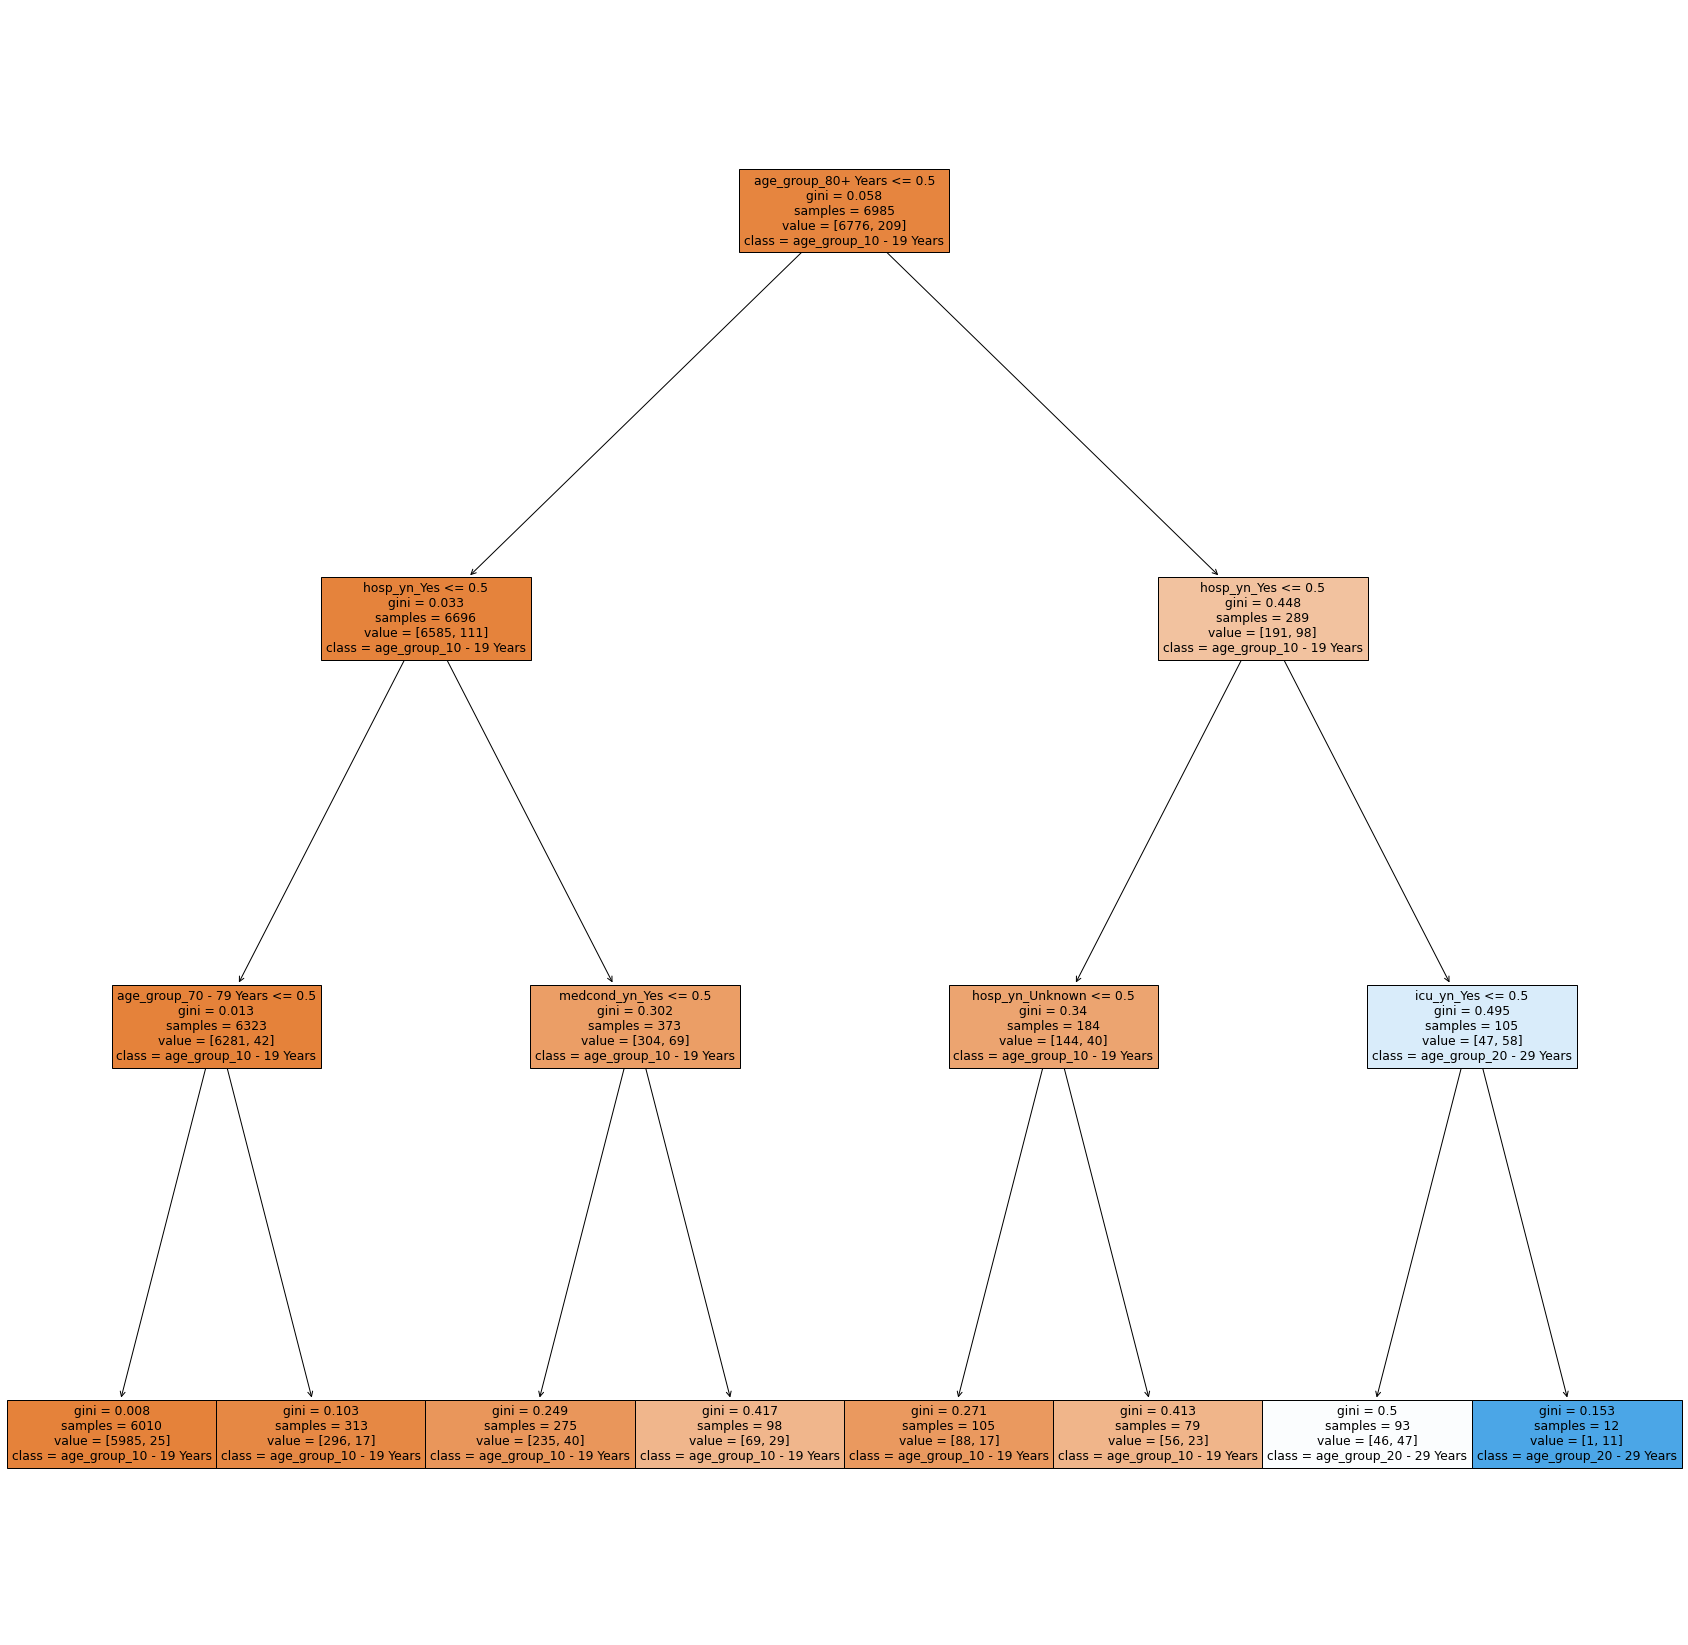

In [76]:
#creating a decision tree and plotting the results 
dtc4 = DecisionTreeClassifier(max_depth=3, random_state=1)
model = dtc4.fit(x_train, y_train)
fig = plt.figure(figsize=(30,30))
_ = tree.plot_tree(model, 
                   feature_names=x_train.columns,  
                   class_names=x_train.columns,
                   filled=True)
plt.savefig('Decision Tree.png')

### Feature importance

Due to the fact that the random forest model is based off of feature importance we can print a ranking of the features in our model in terms of their importance according to the random forest classifier. We can see that the top three features in terms of importance are as expected, these being old age, hospital admission and ICU admission. These results are based on a random forest model containing 100 decision trees. By looking at this table of results we can get a good idea of how we can optimize our model in the next section of this report.

In [77]:
#creating a datframe that shows the random forest feature importance in order 
feature_importance = pd.DataFrame({'feature': x_train.columns, 'importance':rfc.feature_importances_})
feature_importance.sort_values('importance', ascending=False)

,feature,importance
7,age_group_80+ Years,0.262715
9,hosp_yn_Yes,0.259571
11,icu_yn_Yes,0.089032
14,sex_Male,0.082684
10,icu_yn_Unknown,0.070351
13,medcond_yn_Yes,0.043485
6,age_group_70 - 79 Years,0.037391
12,medcond_yn_Unknown,0.032865
8,hosp_yn_Unknown,0.031429
5,age_group_60 - 69 Years,0.027690


## 4.3 Model predictions and metrics 

We will print the predicted target feature value for the first 10 training examples based on training data.

In [82]:
#predicting on the training set
rfc_train_predictions = rfc.predict(x_train)
#creating datframe to show the actual class and the predicted class
df_true_vs_rfc_predicted = pd.DataFrame({'ActualClass': y_train, 'PredictedClass': rfc_train_predictions})
df_true_vs_rfc_predicted.head(10)

,ActualClass,PredictedClass
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,1,0
7,0,0
8,0,0
9,0,0


### Evaluation metrics on training set. 

We will print the classification evaluation measures computed on the training set (e.g. Accuracy, Confusion matrix, Precision, Recall, F1)

In [83]:
#printing evaluation metrics for train data 
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, rfc_train_predictions),"\n")
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, rfc_train_predictions),"\n")
print("Classification report:\n ", metrics.classification_report(y_train, rfc_train_predictions),"\n")
print("=======================================================")

==================== Train Data =======================
Accuracy:  0.9758052970651396 

Confusion matrix: 
 [[6755   21]
 [ 148   61]] 

Classification report:
                precision    recall  f1-score   support

           0       0.98      1.00      0.99      6776
           1       0.74      0.29      0.42       209

    accuracy                           0.98      6985
   macro avg       0.86      0.64      0.70      6985
weighted avg       0.97      0.98      0.97      6985
 



Interpretation of results
- Accuracy
    - Accuracy remains quite high at 0.97
- Precision - How good the model is at prediction the positive class
    - Precision for the Positive class is 0.74
    - Precision for the Negative class is 0.98
- Recall - What percentage of the positive values did we predict
    - Recall for the Positive class is 0.29
    - Recall for the Negative class is 1.
- F1 Score - a weighted average of Precision and recall
    - F1 Score for the Positive class is 0.42
    - F1 Score for the Negative class is 0.99

Summary
- Based on the trainig data, this model has performed marginally better than the logistic model across precision, recall and f1 score.
- The confusion matrix results are very similar to that of the logistic model, we will have to perform a model evaluation on the hold out set before we can make any definitive remarks about model performance.

## 4.4 model evaluation

### Evaluation of metrics on hold out set

We will now do the same evaluation using the test set, these results are printed below along with the training set results for comparison.

In [84]:
#predicting on the test set
rfc_test_predictions = rfc.predict(x_test)

#printing evaluation metrics for train and test data 
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, rfc_train_predictions), "\n")
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, rfc_train_predictions), "\n")
print("Classification report:\n ", metrics.classification_report(y_train, rfc_train_predictions))
print("==================== Test Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_test, rfc_test_predictions))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, rfc_test_predictions))
print("Classification report:\n ", metrics.classification_report(y_test, rfc_test_predictions))
print("======================================================")

==================== Train Data =======================
Accuracy:  0.9758052970651396 

Confusion matrix: 
 [[6755   21]
 [ 148   61]] 

Classification report:
                precision    recall  f1-score   support

           0       0.98      1.00      0.99      6776
           1       0.74      0.29      0.42       209

    accuracy                           0.98      6985
   macro avg       0.86      0.64      0.70      6985
weighted avg       0.97      0.98      0.97      6985

==================== Test Data =======================
Accuracy:  0.9635938543754174
Confusion matrix: 
 [[2875   14]
 [  95   10]]
Classification report:
                precision    recall  f1-score   support

           0       0.97      1.00      0.98      2889
           1       0.42      0.10      0.16       105

    accuracy                           0.96      2994
   macro avg       0.69      0.55      0.57      2994
weighted avg       0.95      0.96      0.95      2994



Interpretation of test set results
- Accuracy
    - Accuracy remains the same as the training set results
- Precision - How good the model is at prediction of the positive class
    - Precision for the Positive class drops significantly form 0.74 to 0.42
    - Precision for the Negative class  remains roughly the same 
    - this can be seen as a good sign as the model is not generalizing 
- Recall - What percentage of the positive values did we predict
    - Recall for the Positive class drops from 0.29 to 0.1
    - Recall for the Negative class  remains at 1.00
- F1 Score - a weighted average of Precision and recall
    - F1 Score for the Positive class drops from 0.42 to 0.16
    - F1 Score for the Negative class ramins roughly the same at 0.99

Summary
-  precision, recall and and f1 score all dropped a significant amount from train set to test set evaluation. Perhaps the model is overfitting.
- We will have to perform cross validation to make a definitive remark on model performance.

### Cross validation metrics

In [85]:
#function to return a dataframe with 10 fold cross validation results on random forest model
def cross_val_RandomForest_DF(X,y, depth=None, estimators=100):
    RandomForestResults = {}
    #metrics to be calculated
    test_metrics = ['accuracy','precision','recall', 'f1']
    for metric in test_metrics:
        result = cross_val_score(RandomForestClassifier(n_estimators=estimators, max_features='auto', oob_score=True, random_state=1, max_depth=depth), X, y, scoring=metric, cv=10)
        #calculate average result for each metric 
        RandomForestResults[metric] = result.mean()
    #creating the dataframe with evaluation metrics results
    RandomForestDF = pd.DataFrame.from_dict(RandomForestResults, orient='index', columns=['Random_Forests'])

    return RandomForestDF

In [86]:
#performing cross validation on the random forest model with full dataset
RandomForestDF = cross_val_RandomForest_DF(x,y)
print(f"Mean results from 10 fold cross validation are:")
RandomForestDF

Mean results from 10 fold cross validation are:


,Random_Forests
accuracy,0.969236
precision,0.526778
recall,0.177520
f1,0.259557


These results are in line with the test set results and marginally worse than the logistic regression cross validation results, particularly the f1 value which is 0.26 compared to the logistic regression which is 0.34. In the next section we will compare the results across the three models in order to get a better idea of which one performed best.

In [87]:
# compute the out-of-bag classification accuracy
rfc.oob_score_

0.9713672154617037

out of bag accuracy score is line with the cross validated accuracy score.

# 5. Improving predictive models

## 5.1 Model Comparisons

- All three of the models have very high accuracy, this however is not due to the model being incredibly accurate at predicting, but rather this naive result is due to the fact that the datset we are working with is highly imbalanced. Therefore in the majority of predictions the models will predict death_yn equal to no, and due to the fact that over 95% of the dataset consists of this response, the model will appear incredibly accurate as a result. 

- We are more concerned with the precision, recall and f1 scores of the models as these give us an idea of how well the models are at predicting a true positve (death_yn equal to yes). We can see that the linear regression model has the highest precision, but the lowest recall, this implies that the model can't detect the class well but is trustable when it does. The logistic and random forest models have similar precision values, while the logistic model has the higher recall of the two. This therefore leaves the logistic model with the highest f1 score of the three models.

- Taking all of this into consideration, it would seem that the logistic model performs better at predicting the target feature. However, we will try to optimize this performance. We will focus on the optimization of the logistic and random forest models in particular.

- It would seem that the linear regression model is not performing very well and therefore will be dropped from our anlysis if it does not improve after we try some feature selection and resampling to improve results. Linear regression models are sensitive to imbalanced data and it may be for this reason that it is producing undesirable results. Logistic regression on the other hand is far more suitable for classification problems and in fact produces the best results in our cross validation analysis.


In [88]:
#concatenating metric results from the three different models
ResultsDF = pd.concat([linreg_crossval_df, logRegDF, RandomForestDF], axis=1)
ResultsDF

,Linear_Regression,Logistic_Regression,Random_Forests
accuracy,0.968470,0.970338,0.969236
precision,0.773333,0.547593,0.526778
recall,0.031295,0.257460,0.177520
f1,0.060018,0.345009,0.259557


### Comparing model to one that always predicts majority class.
Due to the fact that the majority class makes up around 96% of our dataset, we will compare our results to a simple model that predicts the majority class every time.

In [89]:
#printing out the value count of death = yes and death = no with percentage amount in the test set.
death_yn_no = y_test[y_test == 1].count()
death_yn_yes = y_test[y_test == 0].count()
total = death_yn_no+ death_yn_yes
print(f'From original dataset: \t\tCount {total}')
print(f'Total number death=yes:\t {death_yn_no}\t{round(death_yn_no/len(y_test)*100,2)}%')
print(f'Total number death=no:\t {death_yn_yes}\t{round(death_yn_yes/len(y_test)*100,2)}%')

From original dataset: 		Count 2994
Total number death=yes:	 105	3.51%
Total number death=no:	 2889	96.49%


In [90]:
# generate array of 2994 zeros (length of test dataset)
majority = np.zeros(2994)
# create dataframe 
df_majorityClass = pd.DataFrame(majority, columns=['prediction'])
# calculate scores of simple predictin vs actual
print("==================== Test Data vs majority class =======================")
print("Accuracy: ", metrics.accuracy_score(y_test, df_majorityClass))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, df_majorityClass))
print("Classification report:\n ", metrics.classification_report(y_test, df_majorityClass))
print("========================================================================")

==================== Test Data vs majority class =======================
Accuracy:  0.9649298597194389
Confusion matrix: 
 [[2889    0]
 [ 105    0]]
Classification report:
                precision    recall  f1-score   support

           0       0.96      1.00      0.98      2889
           1       0.00      0.00      0.00       105

    accuracy                           0.96      2994
   macro avg       0.48      0.50      0.49      2994
weighted avg       0.93      0.96      0.95      2994



- For predicting death_yn equal to yes the simple model fails completely as expected, all three metrics precision, recall and f1 are 0.
- For predicting death_yn equal to no the simple model does very well as 96% of the dataset consists of death_yn equal to no and therefore it is correct 96% of the time, with a recall of 100% and an f1 score of 98%.
- This simple model is marginally less accurate than our logistic model.


## 5.2 Possible Model Improvements

Unfortunately all of the features that were created in assignment one are not suitable for predicting the target feature, after deriving the new features their relationship with death_yn was analysed and none of them proved to be suitable as predictors. Therefore we will try and improve the models firstly through a process of feature selection. 

### Feature selection

#### All features

As we used a subset of features when training our model, perhaps using all features could improve results. Firstly we must prepare a dataset with all features in the same manner as before and then we will perform cross validation on the resulting dataset. It must be noted that onset_dt was dropped from our analysis as it was deemed not to have a strong relationship with the target feature and contained a large amount of missing values (45%).


In [91]:
df_all = df.copy()
#onset_dt will not be used for any further analysis.
df_all = df_all.drop(["onset_dt"],1)

In [92]:
features = [ 'current_status','sex','age_group','race_ethnicity_combined','hosp_yn','icu_yn','medcond_yn','cdc_case_earliest_dt']
#converting categorical data into dummy or indicator variables 
for col in features:
    dummies = pd.get_dummies(df_all[col], prefix = col, drop_first=True)
    df_all = pd.concat([df_all,dummies], axis = 1)

In [93]:
#dropping unused columns
df_all = df_all.drop(features, axis=1)

In [94]:
#mapping the target feature to binary digits, 1 for yes and 0 for no. 
df_all['death_yn'] = df_all['death_yn'].map({'Yes': 1, 'No': 0})

Dataset with all features has been created, now we can perform cross validation for each model type. Results are as outlined below.

In [95]:
#creating target feature and variables
y = df_all["death_yn"]
X_all = df_all.drop(["death_yn"],1)

In [96]:
print("number of features incl dummies: ", len(X_all.columns))

number of features incl dummies:  28


In [97]:
#performing 10 fold cross validation on each model with all features included
linRegDF_all = cross_val_LinReg_DF(X_all,y)
logRegDF_all = cross_val_LogReg_DF(X_all,y)
RandomForestDF_all = cross_val_RandomForest_DF(X_all,y)

In [98]:
#cross val results of all features
ResultsDF_allFeatures = pd.concat([linRegDF_all, logRegDF_all, RandomForestDF_all], axis=1)
ResultsDF_allFeatures

,Linear_Regression,Logistic_Regression,Random_Forests
accuracy,0.968470,0.970438,0.966430
precision,0.776667,0.554265,0.446703
recall,0.032248,0.238105,0.235786
f1,0.061754,0.329323,0.304861


We can see that the inclusion of all features does not result in any significant gain in performance for the logistic or linear models. However, it does provide a small increase in the metric scores of the random forest model. 


#### Important features

We will now perform cross validation on a model which contains only the top features as produced by the random forest model which have an importance score greater than 5%, these being:
- age_group_80+ Years	
- hosp_yn_Yes	
- icu_yn_Yes	
- sex_Male	


In [100]:
df_top_three = df.copy()
df_top_three = df_top_three[['death_yn','age_group','hosp_yn','icu_yn','sex']]

In [101]:
features = ['age_group','hosp_yn','icu_yn','sex']
#converting categorical data into dummy or indicator variables 
for col in features:
    dummies = pd.get_dummies(df_top_three[col], prefix = col, drop_first=True)
    df_top_three = pd.concat([df_top_three,dummies], axis = 1)

df_top_three = df_top_three.drop(features, axis=1)  

In [102]:
#mapping the target feature to binary digits, 1 for yes and 0 for no. 
df_top_three['death_yn'] = df_top_three['death_yn'].map({'Yes': 1, 'No': 0})  

In [103]:
y = df_top_three["death_yn"]
X_top_three = df_top_three[["age_group_80+ Years","icu_yn_Yes","hosp_yn_Yes","sex_Male"]]

In [104]:
linRegDF_top_three = cross_val_LinReg_DF(X_top_three,y)
logRegDF_top_three = cross_val_LogReg_DF(X_top_three,y)
RandomForestDF_top_three = cross_val_RandomForest_DF(X_top_three,y)

In [105]:
ResultsDF_top_three = pd.concat([linRegDF_top_three, logRegDF_top_three, RandomForestDF_top_three], axis=1)
ResultsDF_top_three

,Linear_Regression,Logistic_Regression,Random_Forests
accuracy,0.968470,0.969637,0.970538
precision,0.773333,0.520858,0.680000
recall,0.031295,0.254435,0.145968
f1,0.060018,0.337557,0.230297


Once again no significant gain in perormance is seen, we will compare the three subsets we have produced so far below.

#### Comparison of different feature subsets

In [106]:
print("\nScores using subset of features: (from part 1)")
print("===================================================================")
print(ResultsDF)
print("\nScores using all features")
print("===================================================================")
print(ResultsDF_allFeatures)
print("\nScores using top features based on random forest importance ")
print("===================================================================")
print(ResultsDF_top_three)


Scores using subset of features: (from part 1)
           Linear_Regression  Logistic_Regression  Random_Forests
accuracy            0.968470             0.970338        0.969236
precision           0.773333             0.547593        0.526778
recall              0.031295             0.257460        0.177520
f1                  0.060018             0.345009        0.259557

Scores using all features
           Linear_Regression  Logistic_Regression  Random_Forests
accuracy            0.968470             0.970438        0.966430
precision           0.776667             0.554265        0.446703
recall              0.032248             0.238105        0.235786
f1                  0.061754             0.329323        0.304861

Scores using top features based on random forest importance 
           Linear_Regression  Logistic_Regression  Random_Forests
accuracy            0.968470             0.969637        0.970538
precision           0.773333             0.520858        0.680000
recal

No significant change when number of features reduced. We can see that the models perform at a similar level across the metrics for each subset of features. Therefore we will firstly try to deal with the dataset imbalance and see if it improves the performance of the models. From this point forward the linear model will not be addressed any further as it simply is not suited to this classification problem, it is consistently producing very low recall scores and therefore will predict a large amount of false negatives. We want to try and minimize false negatives given the nature of the problem. We will therefore attempt to optimize the logistic and random forest models.

## Investigating ways to deal with the target feature imbalance

As discussed already, the dataset target feature we are working with is highly imbalanced. As can be seen below the target feature has 9665 no values and only 314 yes. This disparity can lead to significant bias in the model. There are a number of sampling strategies that can alleviate this bias in the model, two methods in particular that we will test on our model are oversampling and undersampling.

In [107]:
#create a copy of the reduced dataframe
df_balance = df_reduced.copy()

In [108]:
#check the target feature imbalance
df_balance['death_yn'].value_counts()

0    9665
1     314
Name: death_yn, dtype: int64

In [109]:
#create target feature and variables
y = df_balance["death_yn"]
x = df_balance.drop(["death_yn"],1)

#### Undersampling

Random undersampling decreases the number of members of the majority class to the optimal ratio against the minority class. This is the simplest way to undersample, we will use the imbalanced-learn package to execute this method.

In [110]:
undersample = RandomUnderSampler(sampling_strategy='majority')

In [111]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=5)

In [112]:
X_train_under, y_train_under = undersample.fit_resample(x_train, y_train)

After we have undersampled, the training set now contains a 50:50 split in the target feature.

In [113]:
y_train_under.value_counts()

1    209
0    209
Name: death_yn, dtype: int64

In [114]:
# Train on the training sample and test on the test sample.
LogReg2 = LogisticRegression().fit(X_train_under, y_train_under)
LogReg2_test_predictions = LogReg2.predict(x_test)

# Train on the training sample and test on the test sample.
Rfc2 = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1)
Rfc2.fit(X_train_under, y_train_under)
Rfc2_test_predictions = Rfc2.predict(x_test)
print("==================== Undersampled logistic model =======================")
print("Accuracy: ", metrics.accuracy_score(y_test, LogReg2_test_predictions))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, LogReg2_test_predictions))
print("Classification report:\n ", metrics.classification_report(y_test, LogReg2_test_predictions))

print("==================== Undersampled random forest model=======================")
print("Accuracy: ", metrics.accuracy_score(y_test, Rfc2_test_predictions))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, Rfc2_test_predictions))
print("Classification report:\n ", metrics.classification_report(y_test, Rfc2_test_predictions))
print("======================================================")

==================== Undersampled logistic model =======================
Accuracy:  0.8931195724782899
Confusion matrix: 
 [[2585  304]
 [  16   89]]
Classification report:
                precision    recall  f1-score   support

           0       0.99      0.89      0.94      2889
           1       0.23      0.85      0.36       105

    accuracy                           0.89      2994
   macro avg       0.61      0.87      0.65      2994
weighted avg       0.97      0.89      0.92      2994

==================== Undersampled random forest model=======================
Accuracy:  0.8633934535738143
Confusion matrix: 
 [[2501  388]
 [  21   84]]
Classification report:
                precision    recall  f1-score   support

           0       0.99      0.87      0.92      2889
           1       0.18      0.80      0.29       105

    accuracy                           0.86      2994
   macro avg       0.58      0.83      0.61      2994
weighted avg       0.96      0.86      0.90    

Undersampling results in a less accurate prediction by around 10% when compared to previous models, as can be seen from the confusion matrix for both logistic and random forest models the number of false positives is very high which as a result drags down the precision of the model. However it does produce a far higher recall, which may be of benefit to our model. This will be discussed later.

#### Oversampling

Oversampling is essentially the opposite of undersampling in that it duplicate examples in the minority class, such that the minority class is better represented in the dataset.

In [115]:
SMOTE = SMOTE()

In [116]:
X_SMOTE, y_SMOTE = SMOTE.fit_resample(x_train, y_train)

In [117]:
y_SMOTE.value_counts()

1    6776
0    6776
Name: death_yn, dtype: int64

In [118]:
LogReg3 = LogisticRegression().fit(X_SMOTE, y_SMOTE)
LogReg3_test_predictions = LogReg3.predict(x_test)

# Train on the training sample and test on the test sample.
Rfc3 = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1)
Rfc3.fit(X_SMOTE, y_SMOTE)
Rfc3_test_predictions = Rfc3.predict(x_test)

print("==================== Oversampled logtistic model  =======================")
print("Accuracy: ", metrics.accuracy_score(y_test, LogReg3_test_predictions))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, LogReg3_test_predictions))
print("Classification report:\n ", metrics.classification_report(y_test, LogReg3_test_predictions))
print("==================== Oversampled Random forest model =======================")
print("Accuracy: ", metrics.accuracy_score(y_test, Rfc3_test_predictions))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, Rfc3_test_predictions))
print("Classification report:\n ", metrics.classification_report(y_test, Rfc3_test_predictions))
print("======================================================")

==================== Oversampled logtistic model  =======================
Accuracy:  0.8991315965263861
Confusion matrix: 
 [[2603  286]
 [  16   89]]
Classification report:
                precision    recall  f1-score   support

           0       0.99      0.90      0.95      2889
           1       0.24      0.85      0.37       105

    accuracy                           0.90      2994
   macro avg       0.62      0.87      0.66      2994
weighted avg       0.97      0.90      0.93      2994

==================== Oversampled Random forest model =======================
Accuracy:  0.8794255177020708
Confusion matrix: 
 [[2550  339]
 [  22   83]]
Classification report:
                precision    recall  f1-score   support

           0       0.99      0.88      0.93      2889
           1       0.20      0.79      0.31       105

    accuracy                           0.88      2994
   macro avg       0.59      0.84      0.62      2994
weighted avg       0.96      0.88      0.91   

The oversampled logistic model produces the best results out of all the resampled models.

In both models we see a decrease in accuracy from the previous models, however accuracy still remains over 85% which is quite high. We also see a high recall and relatively low precision in both the undersampling and oversampling examples, this indicates that the class is detected well but the model also includes other points of classes in it. This can be seen in the confusion matrix, where in both the over and under sampled models we see a high number of false positives. Recall should be optimized over precision when there is a high cost associated with a  false negative, this is the case with our model as we do not want to predict that a patient is not at risk when they in fact are. Therefore we may consider oversampling our final model in order to strengthen the recall score. 

We first will make a final attempt at optimizing the model by looking at the optimization of the random forest model in particular, using this model we will find the optimum max depth, estimators and number of features. 

## Optimizing random forest

By optimizing the random forest we can then find the find the most important features based on these results. Once again we will prepare the datset to run through the functions that will determine the optimum feature specifications. We remove cdc_case_earliest_dt from the model due to the fact that it will skew the results if left in. As we saw at the beginning of the report, the first quarter of 2020 had a large number of cases and deaths as there was a surge at the beginning of the pandemic. However we saw from the stacked bar plots that this initial surge tapered out as the year progressed and the number of deaths per quarter was quite similar. Therefore to train the model with cdc_case_earliest_dt included would mean we would be training it on very skewed data and as a result if we were to try make predicitons for 2021 this bias would feed into the model. Therefore we have decided to leave these features out. Perhaps in future work this feature could somehow be tansformed to provide more relevant results.

In [119]:
#preparing the dataset 
df_all = df.copy()
#onset_dt will not be used for any further analysis.
df_all = df_all.drop(["onset_dt","cdc_case_earliest_dt"],1)

features = [ 'current_status','sex','age_group','race_ethnicity_combined','hosp_yn','icu_yn','medcond_yn']
#converting categorical data into dummy or indicator variables 
for col in features:
    dummies = pd.get_dummies(df_all[col], prefix = col, drop_first=True)
    df_all = pd.concat([df_all,dummies], axis = 1)

#dropping unused columns
df_all = df_all.drop(features, axis=1)

#mapping the target feature to binary digits, 1 for yes and 0 for no. 
df_all['death_yn'] = df_all['death_yn'].map({'Yes': 1, 'No': 0})
# setup dataframe
y = df_all["death_yn"]
X = df_all.drop(["death_yn"],1)

#### Finding optimal max depth

The optimal model occurs when no max depth is set. The performace of the model gradually increases as the depth increases, we can see that the model performs best when the max depth is set to none i.e There is no maximum depth that you allow the tree to grow to. 

In [120]:
y = df_all["death_yn"]
X_all = df_all.drop(["death_yn"],1)
RandomForest_Depth = pd.DataFrame()
for i in range(1,11):
    df1 = cross_val_RandomForest_DF(X_all,y,i)
    df1.rename(columns={'Random_Forests':f'depth={i}'}, inplace=True)
    RandomForest_Depth = pd.concat([RandomForest_Depth, df1], axis=1)
no_max_depth = cross_val_RandomForest_DF(X_all,y)
no_max_depth.rename(columns={'Random_Forests':f'no_max_depth'}, inplace=True)
RandomForest_Depth = pd.concat([RandomForest_Depth, no_max_depth], axis=1)
RandomForest_Depth

,depth=1,depth=2,depth=3,depth=4,depth=5,depth=6,depth=7,depth=8,depth=9,depth=10,no_max_depth
accuracy,0.968534,0.968534,0.968534,0.968534,0.968935,0.969035,0.969236,0.969236,0.968534,0.969236,0.967833
precision,0.000000,0.000000,0.000000,0.150000,0.433333,0.500000,0.610000,0.570000,0.494167,0.542353,0.486307
recall,0.000000,0.000000,0.000000,0.006452,0.022278,0.028528,0.057056,0.082560,0.098589,0.143044,0.245363
f1,0.000000,0.000000,0.000000,0.012311,0.041754,0.053182,0.101798,0.139851,0.159967,0.220968,0.319377


#### Finding optimal number of estimators

We can see that precision and recall improve up until 100 estimators and then it begins to level out, therefore we will keep the number of estimators at the default amount of 100.

In [121]:
# setup dataframe
y = df_all["death_yn"]
X = df_all.drop(["death_yn"],1)
# initialised empty dataframe
RandomForest_Estimators = pd.DataFrame()
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
#perform cross validation with a range of different estimator values
for item in n_estimators:
    df1 = cross_val_RandomForest_DF(X,y,estimators=item)
    df1.rename(columns={'Random_Forests':f'estimators={item}'}, inplace=True)
    RandomForest_Estimators = pd.concat([RandomForest_Estimators, df1], axis=1)
RandomForest_Estimators

,estimators=1,estimators=2,estimators=4,estimators=8,estimators=16,estimators=32,estimators=64,estimators=100,estimators=200
accuracy,0.962722,0.966730,0.966529,0.966930,0.966530,0.966831,0.967232,0.967833,0.967532
precision,0.359391,0.451712,0.432902,0.458166,0.443496,0.457795,0.464766,0.486307,0.473562
recall,0.238306,0.238407,0.219153,0.254839,0.251714,0.257964,0.251613,0.245363,0.248488
f1,0.283068,0.304450,0.287093,0.322036,0.317462,0.322448,0.321625,0.319377,0.321079


#### Finding optimal number of features

The max depth and number of estimators we have already been using are the optimal amount for the model, for this reason we will attempt once again to find the best subset of features that allow for optimal performance of the model. As explained earlier, due to the fact that the random forest model produces predictions based on feature importance we can attempt to find the optimal number of features for the model based on their importance. 

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1 , test_size=0.3)
# Train RF with 100 trees
rfc = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1)
rfc.fit(X_train, y_train)
importance = pd.DataFrame({'feature': X_train.columns, 'importance':rfc.feature_importances_})
importance.sort_values('importance', ascending=False, inplace=True)
importance.set_index('feature',1, inplace=True)
importance

,importance
feature,
hosp_yn_Yes,0.201855
age_group_80+ Years,0.159232
sex_Male,0.085156
icu_yn_Unknown,0.055445
current_status_Probable Case,0.045397
icu_yn_Yes,0.044246
age_group_70 - 79 Years,0.043796
hosp_yn_Unknown,0.042789
"race_ethnicity_combined_White, Non-Hispanic",0.037627


The feature importance for all features is as expected with hospilization at the top, followed by old age and interestingly gender is the third most important factor. We will now use this listing in order to find the optimal number of features for the random forest model. We will iterate over the list increasing the number of features included each time and will perform cross validation to produce some metrics for each iteration, these will then be stored in a dataframe.

In [123]:
#empty array to store list of features
list_features = []
RandomForest_Features = pd.DataFrame()
count=0
#iterate over the feature importance list and perform cross validation for each iteration
for index, row in importance.iterrows():
    if count < 20:
        list_features.append(index)
        X = df_all[list_features]
        df1 = cross_val_RandomForest_DF(X,y,estimators=100, depth=None)
        df1.rename(columns={'Random_Forests':f'features={len(list_features)}'}, inplace=True)
        RandomForest_Features = pd.concat([RandomForest_Features, df1], axis=1)
        count+=1
    else:
        break
RandomForest_Features 

,features=1,features=2,features=3,features=4,features=5,features=6,features=7,features=8,features=9,features=10,features=11,features=12,features=13,features=14,features=15,features=16,features=17,features=18,features=19,features=20
accuracy,0.968534,0.969637,0.970137,0.969737,0.970038,0.970037,0.969737,0.969737,0.969136,0.968434,0.968534,0.967632,0.967131,0.967733,0.967332,0.967232,0.966731,0.967432,0.967031,0.967031
precision,0.000000,0.520858,0.643651,0.571970,0.574549,0.601677,0.568874,0.578874,0.520533,0.513550,0.511958,0.464275,0.462115,0.490786,0.463557,0.469182,0.454179,0.477604,0.461453,0.457596
recall,0.000000,0.254435,0.126815,0.149294,0.165524,0.136593,0.143044,0.139819,0.190726,0.213407,0.226008,0.215927,0.206956,0.229234,0.217137,0.235887,0.223185,0.239012,0.232661,0.235786
f1,0.000000,0.337557,0.204113,0.231012,0.247540,0.215639,0.222515,0.217896,0.276395,0.295721,0.308611,0.291535,0.281569,0.307729,0.290998,0.309284,0.295770,0.313956,0.305379,0.306466


We must remember that with our model there is a high cost associated with a false negative, meaning that we need to reduce the number of cases where a prediciton is made as 0 when the target value is actually 1 i.e when a person is at high risk of dying from covid-19 but the model predicts it incorrectly. However we also do not want to produce a large number of false positives either, where the model predicts 1 when the actual value is 0. Therefore the optimal amount of features based on the above results is 11. Due to the fact that we are dealing with a higly imblanced dataset it is quite difficult to find a balance between precision and recall as can be seen from the results above, for this reason we may have to prioritize one over the other for our final model. 

We will now perform cross validation on the logistic and random forest models using optimal features.

In [124]:
#creating a list of the optimal features 
optimum_features = list_features[0:11]

In [125]:
#displaying the optimal features
optimum_features

['hosp_yn_Yes',
 'age_group_80+ Years',
 'sex_Male',
 'icu_yn_Unknown',
 'current_status_Probable Case',
 'icu_yn_Yes',
 'age_group_70 - 79 Years',
 'hosp_yn_Unknown',
 'race_ethnicity_combined_White, Non-Hispanic',
 'race_ethnicity_combined_Unknown',
 'race_ethnicity_combined_Hispanic/Latino']

In [126]:
#performing corss validation for the logistic and random forest models using the optimal features
y = df_all["death_yn"]
X = df_all[optimum_features]
print("Number of features: ", len(X.columns))
logRegDF_optimum = cross_val_LogReg_DF(X,y)
RandomForestDF_optimum = cross_val_RandomForest_DF(X,y,depth=None,estimators=100)
# merge all 3 models into dataframe
ResultsDF_optimum_features = pd.concat([logRegDF_optimum, RandomForestDF_optimum], axis=1)
ResultsDF_optimum_features

Number of features:  11


,Logistic_Regression,Random_Forests
accuracy,0.968735,0.968534
precision,0.492094,0.511958
recall,0.219153,0.226008
f1,0.298318,0.308611


In [127]:
print("\nScores using subset of features: (from part 1)")
print("===================================================================")
print(ResultsDF)
print("\nScores using all features")
print("===================================================================")
print(ResultsDF_allFeatures)
print("\nScores using top features based on random forest importance ")
print("===================================================================")
print(ResultsDF_top_three)
print("\nScores using optimum features ")
print("===================================================================")
print(ResultsDF_optimum_features)


Scores using subset of features: (from part 1)
           Linear_Regression  Logistic_Regression  Random_Forests
accuracy            0.968470             0.970338        0.969236
precision           0.773333             0.547593        0.526778
recall              0.031295             0.257460        0.177520
f1                  0.060018             0.345009        0.259557

Scores using all features
           Linear_Regression  Logistic_Regression  Random_Forests
accuracy            0.968470             0.970438        0.966430
precision           0.776667             0.554265        0.446703
recall              0.032248             0.238105        0.235786
f1                  0.061754             0.329323        0.304861

Scores using top features based on random forest importance 
           Linear_Regression  Logistic_Regression  Random_Forests
accuracy            0.968470             0.969637        0.970538
precision           0.773333             0.520858        0.680000
recal

**Summary**: Obviously using the optimal features as decided by the random forest model does optimize the random forest itself, but this does not translate to the logistic model. When these features are used in the logistic model they actually pull down the all four metrics when compared to the other subsets of features. The logistic model using the subset of features from part one still performs better. In fact it is the best performing model out of the lot.

As one final step we will take this model and train it on an oversampled dataset as discussed in the previous section. The results can be seen below. While it is by no means a perfect model, it has the highest recall of all of the models, which is very important for this task as we want to produce as little false negatives as possible. This is due to the fact that there is a high cost associated with a false negative i.e. there is room for error in terms of false positives as the patient is not at risk but will be told they are, however if a patient is told they are not at risk when they are in fact at risk this could lead to complications. In essence, it is better for a patient to know that they may be at risk, regardless of if they actually are! 

The linear regression model has the worst performance across the board, while the logistic and random forest perform almost the exact same. By means of oversampling we are able to tune the model training such that it predicts the positive class in higher quantities. While this model does produce quite a few false positives as a result, this is a trade off we must deal with in order to ensure that false negatives are as low as possible. The metrics of this model can be seen below when used for predictions of the test set. We obtain a very high recall of 84%, but quite a low precision of 24%. However, we are willing to make this trade off in order to ensure that patients are rarely categorized as 'not at risk' when they very well could be. 

In [147]:
from imblearn.over_sampling import SMOTE
y = df_balance["death_yn"]
x = df_balance.drop(["death_yn"],1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=5)
SMOTE = SMOTE()
X_SMOTE, y_SMOTE = SMOTE.fit_resample(x_train, y_train)
Final_Model = LogisticRegression().fit(X_SMOTE, y_SMOTE)
Final_test_predictions = Final_Model.predict(x_test)
print("==================== Final Model on test set  =======================")
print("Accuracy: ", metrics.accuracy_score(y_test, Final_test_predictions))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, Final_test_predictions))
print("Classification report:\n ", metrics.classification_report(y_test, Final_test_predictions))

==================== Final Model on test set  =======================
Accuracy:  0.8954575818303273
Confusion matrix: 
 [[2591  298]
 [  15   90]]
Classification report:
                precision    recall  f1-score   support

           0       0.99      0.90      0.94      2889
           1       0.23      0.86      0.37       105

    accuracy                           0.90      2994
   macro avg       0.61      0.88      0.65      2994
weighted avg       0.97      0.90      0.92      2994



## 5.3 Model Evaluation

### Evaluation on the test dataset provided 

We must modify the test dataset such that it complys with our model, this involves transforming the data generally in the same way that the training data was transformed originally. This process can be seen below.

In [129]:
#read in the dataset
test_df = pd.read_csv('24032021-covid19-cdc-deathyn-recent-10k .csv')

In [130]:
#Select all columns of type 'object'
object_columns = test_df.select_dtypes(['object']).columns
object_columns
#Convert selected columns to type 'category'
for column in object_columns:
    test_df[column] = test_df[column].astype('category')

In [131]:
#replacing all missing values with NaN
test_df  = test_df.replace('Missing', np.NaN)

In [132]:
#data imputation - replace all NaN values with 'Unknown'
test_df['hosp_yn'] = test_df['hosp_yn'].fillna('Unknown') 
test_df['medcond_yn'] = test_df['medcond_yn'].fillna('Unknown') 
test_df['icu_yn'] = test_df['icu_yn'].fillna('Unknown') 

In [133]:
#drop all unused columns
test_df = test_df.drop(['cdc_case_earliest_dt','cdc_report_dt','pos_spec_dt','onset_dt','current_status','race_ethnicity_combined'], axis = 1) 

In [134]:
#data imputation - replace all NaN values with 'Unknown'
test_df = test_df[test_df['age_group'].notna()]
test_df = test_df[test_df['sex'].notna()]

In [135]:
# Prepare %missing column
missing  = 100 * (test_df.isnull().sum()/df.shape[0])
# store the values in a dataframe
missing = pd.DataFrame(missing, columns=['%missing'])
missing

,%missing
sex,0.0
age_group,0.0
hosp_yn,0.0
icu_yn,0.0
death_yn,0.0
medcond_yn,0.0


In [136]:
#converting categorical data into dummy or indicator variables 
variables = ['age_group','hosp_yn','icu_yn','medcond_yn','sex']
for col in variables:
    dummies = pd.get_dummies(test_df[col],prefix = col, drop_first=True)
    test_df = pd.concat([test_df,dummies], axis = 1)

In [137]:
#dropping unused columns
test_df = test_df.drop(variables, axis=1)

In [138]:
#mapping the target feature to binary digits, 1 for yes and 0 for no. 
test_df['death_yn'] = test_df['death_yn'].map({'Yes': 1, 'No': 0})

In [139]:
#creating variables and target feature 
x_testdf = test_df.drop('death_yn',axis=1)
y_testdf = test_df['death_yn']

In [140]:
#drop columns that are not in original dataset
x_testdf = x_testdf.drop('sex_Other',axis=1)

The dataframe is now prepped and ready to be passed into our final model.

In [141]:
Final_predictions = Final_Model.predict(x_testdf)

print("==================== Test Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_testdf, Final_predictions))
print("Confusion matrix: \n", metrics.confusion_matrix(y_testdf, Final_predictions))
print("Classification report:\n ", metrics.classification_report(y_testdf, Final_predictions))
print("======================================================")

==================== Test Data =======================
Accuracy:  0.8929537937255688
Confusion matrix: 
 [[8812 1045]
 [  23   97]]
Classification report:
                precision    recall  f1-score   support

           0       1.00      0.89      0.94      9857
           1       0.08      0.81      0.15       120

    accuracy                           0.89      9977
   macro avg       0.54      0.85      0.55      9977
weighted avg       0.99      0.89      0.93      9977



Just for some comparison, if we compare this with the logistic model that has not been trained on oversampled data we can see a total of 86 people who died from covid-19 would not have been categorized as high risk by this model, this number of false negatives is more than halved in our oversampled model. Of course the number of false positives is far lower than the oversampled model, but this is the trade off that we must allow for given the nature of what we are predicting. We want to ensure that patients who are at risk know they are at risk, regardless of whether they truely are or not. 

In [142]:
Final_predictions2 = LogReg.predict(x_testdf)
print("==================== Test Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_testdf, Final_predictions2))
print("Confusion matrix: \n", metrics.confusion_matrix(y_testdf, Final_predictions2))
print("Classification report:\n ", metrics.classification_report(y_testdf, Final_predictions2))
print("======================================================")

==================== Test Data =======================
Accuracy:  0.9865691089505864
Confusion matrix: 
 [[9809   48]
 [  86   34]]
Classification report:
                precision    recall  f1-score   support

           0       0.99      1.00      0.99      9857
           1       0.41      0.28      0.34       120

    accuracy                           0.99      9977
   macro avg       0.70      0.64      0.66      9977
weighted avg       0.98      0.99      0.99      9977



**Summary of results:**

Ideally we would like a model that has both high recall and high precision. However, we have found that this is quite difficult to achieve due to the imbalanced nature of the data set. while we could have produced a model that produced roughly equal but low precision and recall, it was decided that due to the nature of the prediction that it would be better to have the model tuned such that the recall is greater than precision. As explained previously we want to keep the amount of false negatives predicted by the model as low as possible. The purpose of the model is to predict how at risk a patient is if they are infected with covid-19. As such, we accept the lower cost of additional worry that more False Positives might entail before risk of death as a result of covid-19 is ruled out. In other words, we want to minimise False Negatives at the risk of increasing False Positives.

## 5.4 Conclusions
- 3 predictive models have been evaluated in this notebook. The linear regression model proved to be the worst at producing predictions of the three, while the random forest and logistic regression models performed similarly, with the logistic model being marginally better 
- The large majority of the features in the dataset have been found to have little impact on the target feature, with only the top few having any significant impact (hospilization, old age, ICU admission, sex etc.)
- It was difficult to optimize the models, a number of techniques were tried but none seemed to produce any significant improvements form the baseline model used. While resampling the training data did improve recall significantly, it consequently brought down the precision of the model.
- In the end it was decided that a trade off would have to be made between precision and recall, and due to the nature of the problem it was decided that recall would be prioritized.
- While there is most definitely room for improvements with this model, given that we were working with such an imbalanced dataset it was no easy task to produce a well balanced model.
- For future work perhaps it would be worth while deriving some new features that could be of use, particularly datetime features that could properly capture the trends in death rates throughout the year. As well as this we could re-evaluate each model on the whole dataset and perhaps some additional evaluation measures could be incorporated such as ROC and AUC such that we could get a better idea of how well the classifier is performing. 




